In [3]:
%load_ext autoreload
%autoreload 2

from scint_funcs import data_dedisp_derip_filled_masked, acf_scint_plot, acf_per_subband, make_scallop_model 
import chime_frb_api #needed for CHIME internal - will update with publically available data
from baseband_analysis.core.sampling import _upchannel as upchan
import numpy as np
import matplotlib.pyplot as plt
from baseband_analysis.core.signal import get_main_peak_lim
import json
import os
from baseband_analysis.core.sampling import scrunch

import matplotlib
from lmfit import minimize, Parameters, fit_report, Model, Minimizer, report_fit
from scipy.optimize import curve_fit
from baseband_datamodel import DataModel
import chime_frb_constants as constants
import scipy

%matplotlib inline

import matplotlib.gridspec as gridspec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[2024-08-28 18:54:58,976] INFO Authorization Method: Tokens
[2024-08-28 18:54:59,900] INFO Authorization Token : Expired
[2024-08-28 18:54:59,901] INFO Reauthorize Method: Tokens
[2024-08-28 18:55:01,516] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2024-08-28 18:55:01,517] INFO Reauthorize Result: Passed


In [4]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 9
mpl.rcParams['font.family'] = 'sans-serif'                                                                                                                           
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.major.pad']='6'
mpl.rcParams['ytick.major.pad']='6'


In [5]:

#at the moment needs access to CHIME database to access data, will provide data products upon request 
#(and will be public when the work is published)

master = chime_frb_api.frb_master.FRBMaster(base_url = "https://frb.chimenet.ca/frb-master")
master.API.authorize()
auth = {"Authorization": master.API.access_token}

[2024-08-28 18:55:04,060] INFO Authorization Method: Tokens
[2024-08-28 18:55:04,242] INFO Authorization Token : Expired
[2024-08-28 18:55:04,243] INFO Reauthorize Method: Tokens
[2024-08-28 18:55:04,377] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2024-08-28 18:55:04,377] INFO Reauthorize Result: Passed


## Relevant info on FRB

In [6]:
event_id = '247411829'
dm=116.8371

In [7]:
def doublelorentz_w_c(x,gamma1,m1,gamma2,m2,c):
        return m1**2 / (1+(x/gamma1)**2) + m2**2 / (1+(x/gamma2)**2) +c
    
def lorentz_w_c(x,gamma1,m1,c):
        return m1**2 / (1+(x/gamma1)**2) + c
    
def triplelorentz(x,gamma1,m1,gamma2,m2,gamma3,m3):
        return m1**2 / (1+(x/gamma1)**2) + m2**2 / (1+(x/gamma2)**2) + m3**2 / (1+(x/gamma3)**2) 
    
def lorentz(x,gamma1,m1):
        return m1**2 / (1+(x/gamma1)**2)

In [8]:
def lorentz_withc_min(params,x,y,err):
        gamma1 = params['gamma1'].value
        m1 = params['m1'].value
        c = params['c'].value
        
        modulo= m1**2 / (1+(x/gamma1)**2) +c
        return (modulo-y)/err
    
def doublelorentz_withc_min(params,x,y,err):
        gamma1 = params['gamma1'].value
        m1 = params['m1'].value
        gamma2 = params['gamma2'].value
        m2 = params['m2'].value
        c = params['c'].value
        
        modulo= m1**2 / (1+(x/gamma1)**2) + m2**2 / (1+(x/gamma2)**2) +c
        return (modulo-y)/err
    
    
def triplelorentz_min(params,x,y,err):
        gamma1 = params['gamma1'].value
        m1 = params['m1'].value
        gamma2 = params['gamma2'].value
        m2 = params['m2'].value
        gamma3 = params['gamma3'].value
        m3 = params['m3'].value
        
        modulo= m1**2 / (1+(x/gamma1)**2) + m2**2 / (1+(x/gamma2)**2) + m3**2 / (1+(x/gamma3)**2)
        return (modulo-y)/err 

## Load in the baseband data

[2024-08-28 18:55:04,676] INFO Reauthorize Method: Tokens
[2024-08-28 18:55:06,297] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2024-08-28 18:55:06,298] INFO Reauthorize Result: Passed
/arc/home/knimmo/local_software/fitburst_morphology/baseband-analysis/baseband_analysis/core/signal.py:106: RuntimeWarning: Mean of empty slice
  if not np.isnan(np.nanmean(power_in[-1], axis=0)).any():
/arc/home/knimmo/local_software/fitburst_morphology/baseband-analysis/baseband_analysis/core/flagging.py:103: RuntimeWarning: Mean of empty slice
  spect = get_spect(np.nanmean(power_beam, axis=-1), thres=thres_mean)
/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


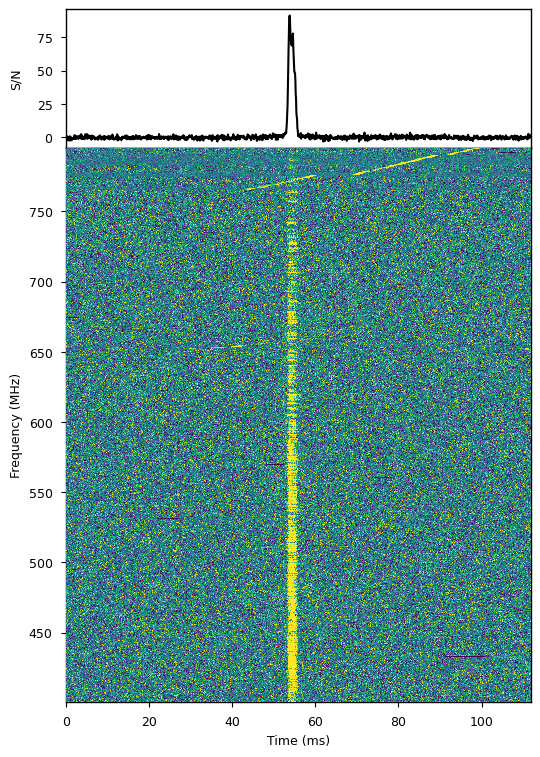

116.8371 116.8371 0


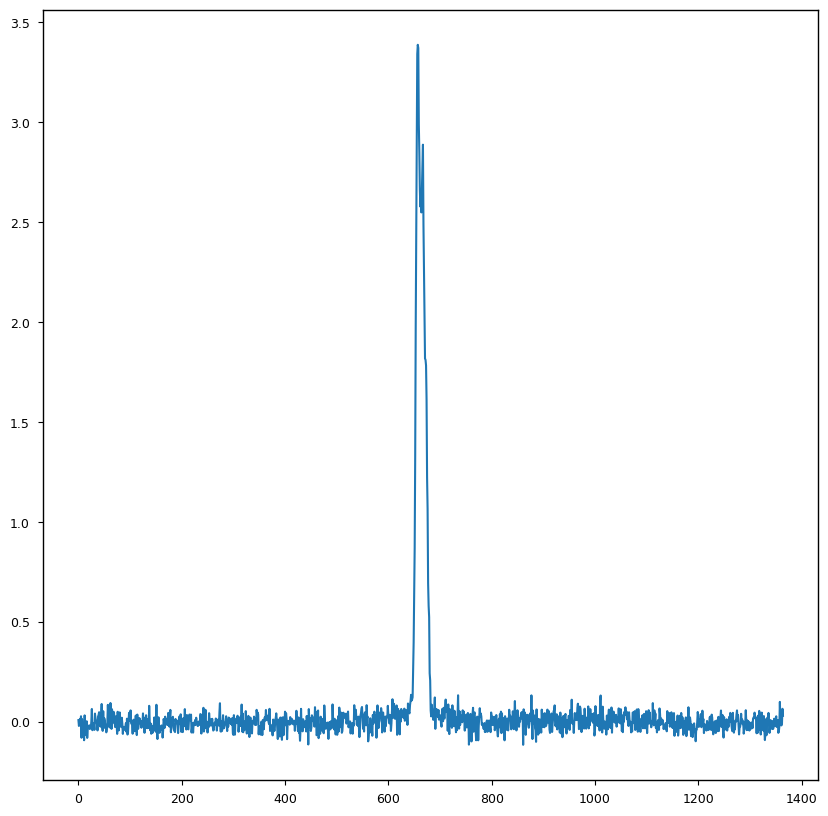

Please define the bin range to use for the off burst statistics (beginbin,endbin):  0,500


/arc/home/knimmo/local_software/fitburst_morphology/baseband-analysis/baseband_analysis/core/sampling.py:546: RuntimeWarning: Mean of empty slice
  wfall = np.nanmean(
/arc/home/knimmo/local_software/fitburst_morphology/baseband-analysis/baseband_analysis/core/sampling.py:552: RuntimeWarning: Mean of empty slice
  wfall = np.nanmean(


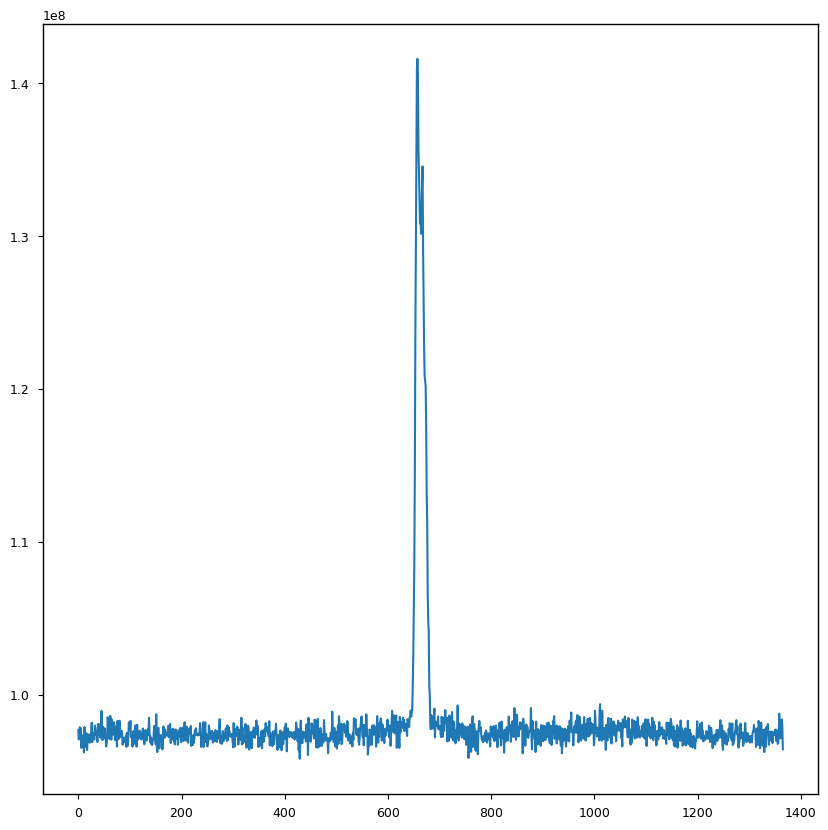

Please define the time bin range to keep (beginbin,endbin):  0,1000


/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Figure size 1000x1000 with 0 Axes>

In [9]:
data, freq, freqid = data_dedisp_derip_filled_masked(event_id, dm, downsample_factor=32,interactive=True)

## load in off burst data from same baseband dump

[2024-08-28 18:55:55,606] INFO Reauthorize Method: Tokens
[2024-08-28 18:55:57,392] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2024-08-28 18:55:57,393] INFO Reauthorize Result: Passed


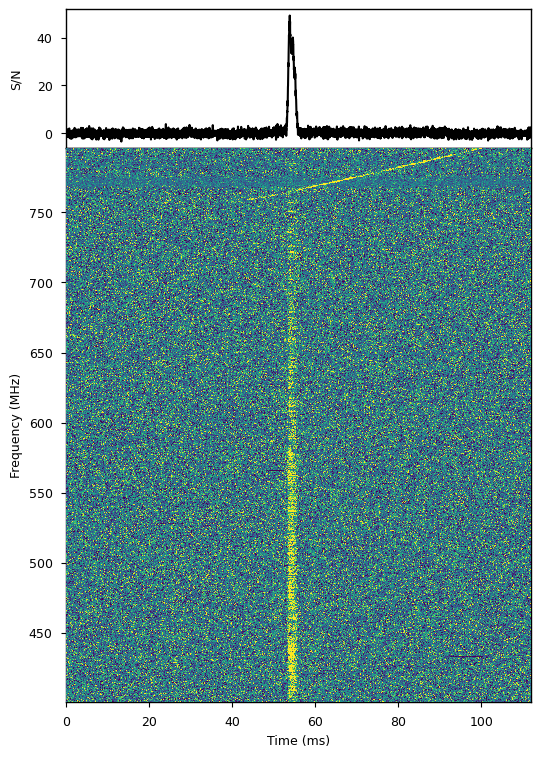

116.8371 116.8371 0


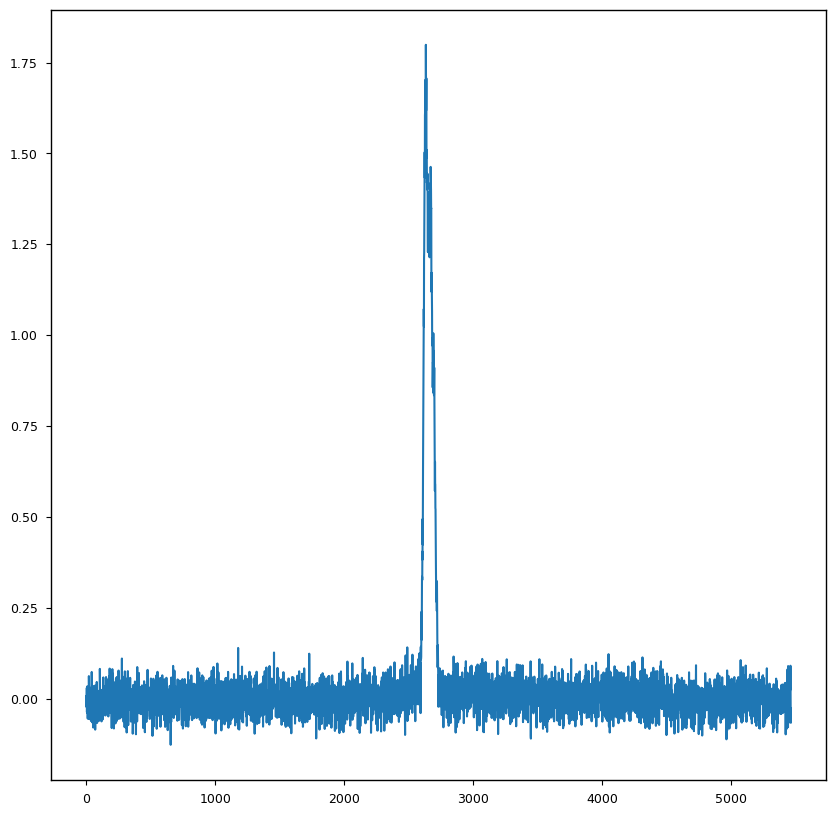

Please define the bin range to use for the off burst statistics (beginbin,endbin):  0,2000


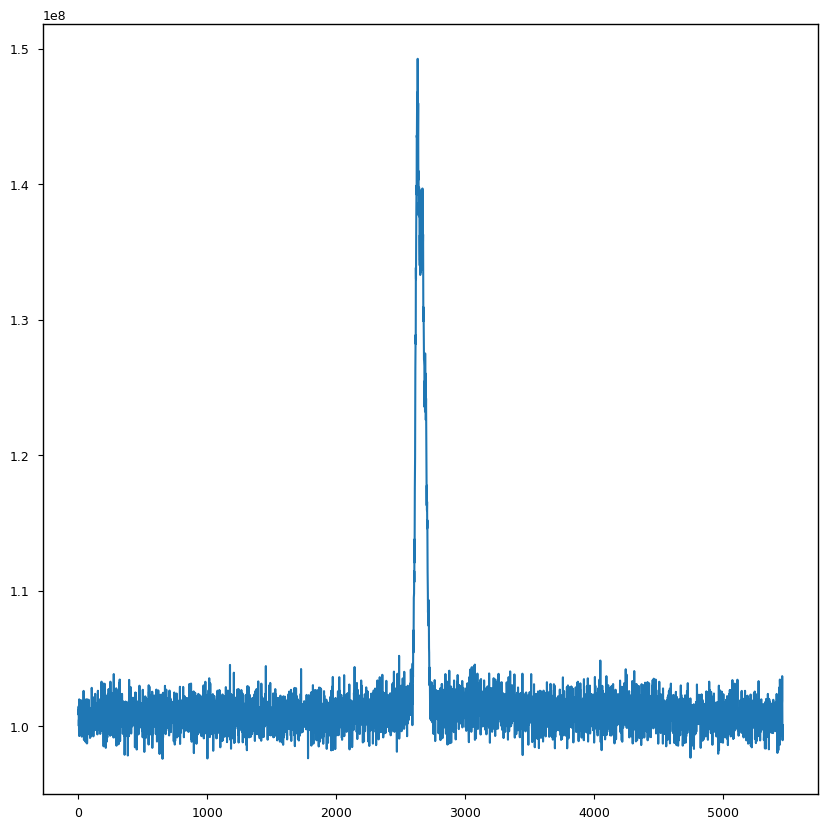

Please define the time bin range to keep (beginbin,endbin):  0,2000


<Figure size 1000x1000 with 0 Axes>

In [10]:
data_fake, freq_fake, freqid_fake = data_dedisp_derip_filled_masked(event_id, dm, downsample_factor=8,interactive=True,off=True)

# Dynamic spectrum plot 
## with time dependent modulation index

In [11]:
#upchannelise for the plot
fftsize=16
downfreq=1
data_dedisp_derippled_masked_upchan_ds = upchan(data,freqid,fftsize=fftsize,downfreq=downfreq)
#upchannel the noise to model the scalloping
noise_dedisp_derippled_masked_upchan_ds = upchan(data_fake,freqid_fake,fftsize=fftsize,downfreq=downfreq)

model_ds, off_corrected_spec_ds, inds_ds = make_scallop_model(noise_dedisp_derippled_masked_upchan_ds[0], fftsize, downfreq)

In [12]:
power = np.abs(data_dedisp_derippled_masked_upchan_ds[0]**2)
I_upchan_ds = np.sum(power,axis=0).T

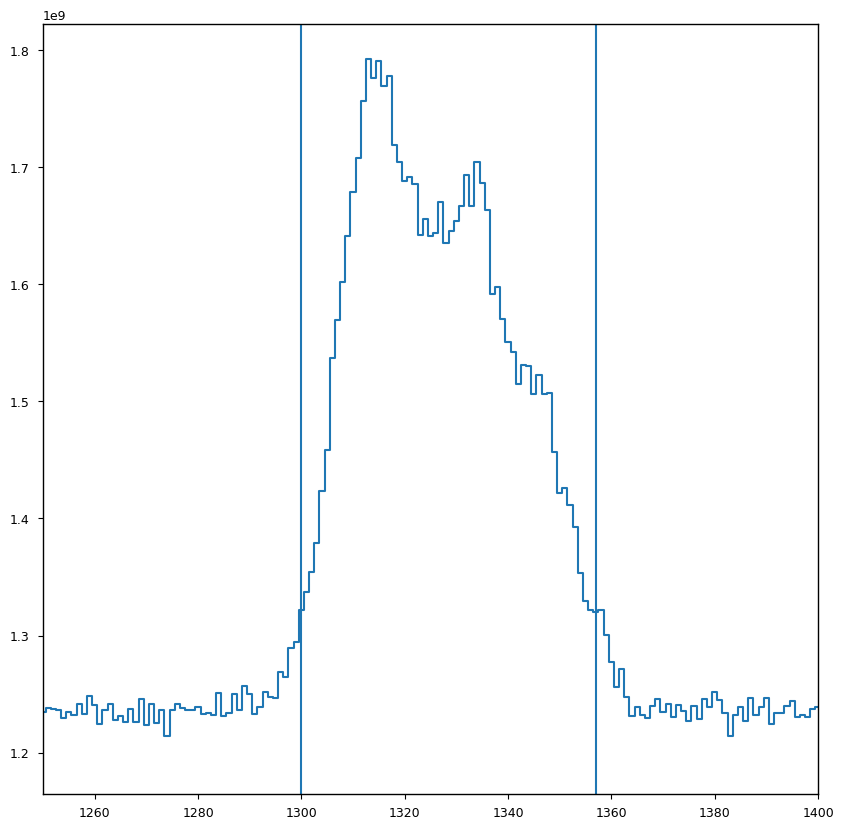

In [13]:
plt.plot(np.nanmean(I_upchan_ds,axis=0), drawstyle='steps-mid')
plt.xlim(2500//2,2800//2)
plt.axvline(2600//2)
plt.axvline(2715//2)
plt.show()

In [14]:
#per channel I want to remove the scalloping and normalise using off burst data
I_upchan_corrected = np.zeros_like(I_upchan_ds)
for time_bin in range(I_upchan_ds.shape[1]):
    I_upchan_corrected[:,time_bin] = I_upchan_ds[:,time_bin]/model_ds
    
    
for freq_chan in range(I_upchan_corrected.shape[0]):
    Ioff=I_upchan_corrected[freq_chan,:600]
    I_upchan_corrected[freq_chan,:] = I_upchan_corrected[freq_chan,:] - np.nanmean(Ioff)
    Ioff-=np.nanmean(Ioff)
    I_upchan_corrected[freq_chan,:] = I_upchan_corrected[freq_chan,:] / np.nanstd(Ioff)

    

/tmp/ipykernel_35/2656967186.py:11: RuntimeWarning: invalid value encountered in divide
  I_upchan_corrected[freq_chan,:] = I_upchan_corrected[freq_chan,:] / np.nanstd(Ioff)


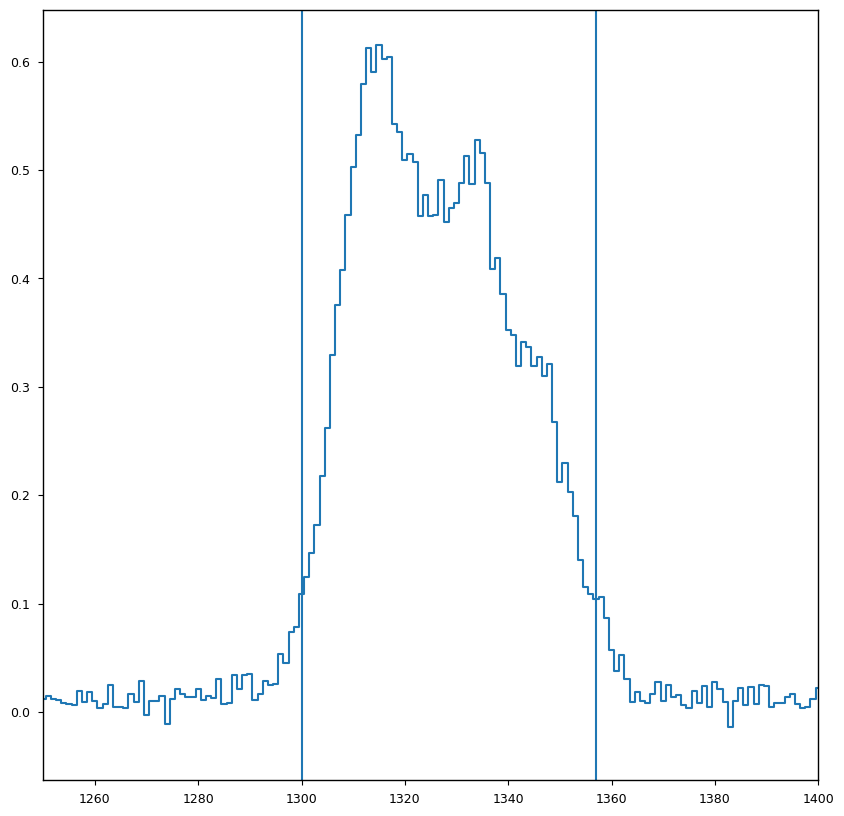

In [15]:
plt.plot(np.nanmean(I_upchan_corrected,axis=0), drawstyle='steps-mid')
plt.xlim(2500//2,2800//2)
plt.axvline(2600//2)
plt.axvline(2715//2)
plt.show()

In [16]:
prof_sn = np.nanmean(I_upchan_corrected,axis=0)
prof_off = prof_sn[:2400//2]
prof_sn -=np.nanmean(prof_off)
prof_off = prof_sn[:2400//2]
prof_sn/=np.nanstd(prof_off)

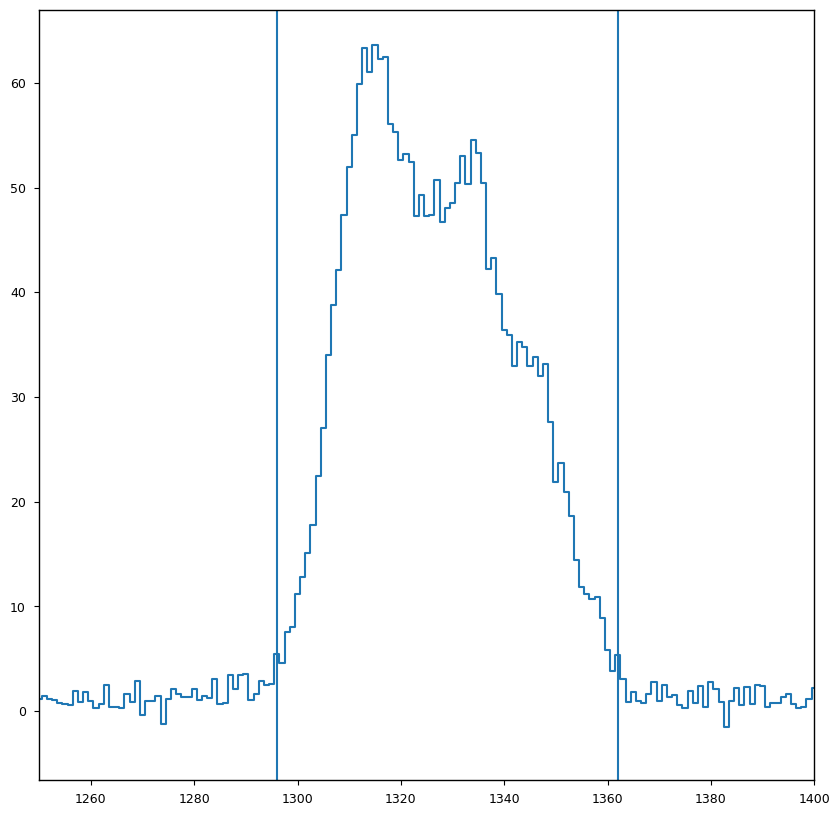

In [17]:
plt.plot(prof_sn, drawstyle='steps-mid')
plt.xlim(2500//2,2800//2)
plt.axvline(np.where(prof_sn > 5)[0][0])
plt.axvline(np.where(prof_sn > 5)[0][-1])
plt.show()

In [18]:
spec_fake = np.nanmean(I_upchan_corrected[:,0:2000//2],axis=1)

spec_fake[np.isnan(spec_fake)]=0
spec_fake=np.ma.masked_where(spec_fake==0,spec_fake)

calib_off=spec_fake-np.nanmean(spec_fake)
calib_off/=np.std(calib_off)
newinds=np.where(np.abs(calib_off)>3)[0]
print(newinds)

I_upchan_corrected[newinds,:]=0
I_upchan_corrected = np.ma.masked_where(I_upchan_corrected==0,I_upchan_corrected) 

/tmp/ipykernel_35/766746143.py:1: RuntimeWarning: Mean of empty slice
  spec_fake = np.nanmean(I_upchan_corrected[:,0:2000//2],axis=1)


[  441   791  3475  3704  3770  3786  3949  4228  4443  5099  5173  5277
  5314  5485  6567  6609  7590  7632  8129  8135  9773 10560 11916 12013
 12146 12164 12215 12504 13094 13098 13202 14086 14105 14201 15821 16031]


/tmp/ipykernel_35/758788023.py:12: RuntimeWarning: Mean of empty slice
  spec_upchan = np.nanmean(I_upchan_corrected[:,i-2:i+2],axis=1)
/tmp/ipykernel_35/758788023.py:15: RuntimeWarning: Mean of empty slice
  spec_fake = np.nanmean(I_upchan_corrected[:,1200:1204],axis=1)


Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2751.10it/s]


Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 244
    # variables        = 3
    chi-square         = 40.7733851
    reduced chi-square = 0.16918417
    Akaike info crit   = -430.549839
    Bayesian info crit = -420.058334
[[Variables]]
    gamma1:  0.03351829 +/- 0.02103889 (62.77%) (init = 0.2)
    m1:      1.54915123 +/- 0.69702636 (44.99%) (init = 1)
    c:       0.24253364 +/- 0.01537226 (6.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9940
    C(gamma1, c)  = -0.2947
    C(m1, c)      = +0.2616
None


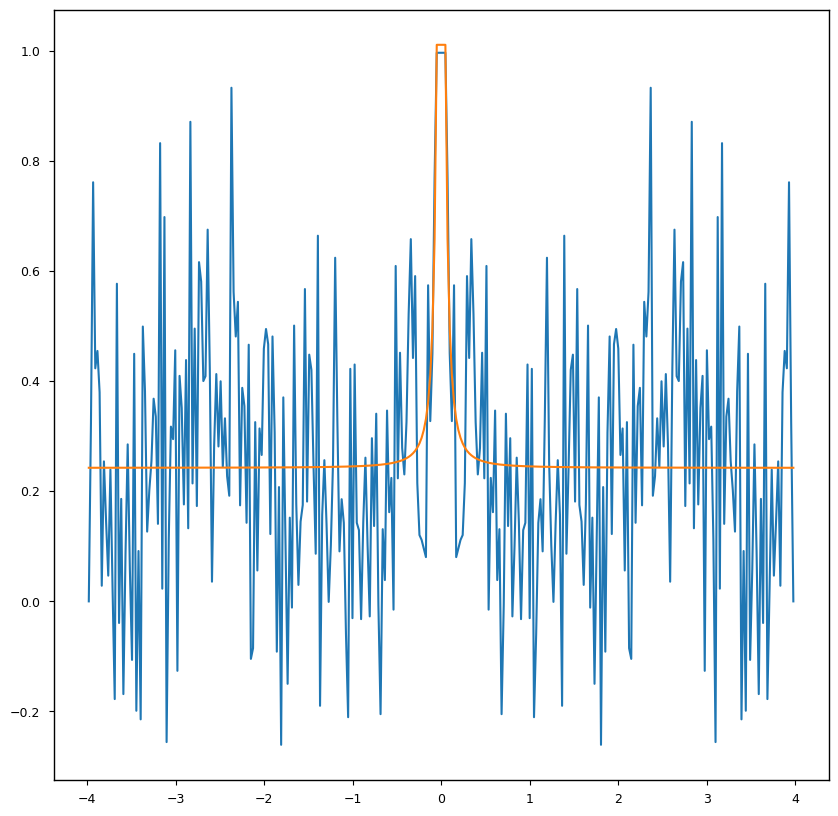

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2849.20it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 4.80899175
    reduced chi-square = 0.01995432
    Akaike info crit   = -952.110110
    Bayesian info crit = -941.618605
[[Variables]]
    gamma1:  0.07000955 +/- 0.00696184 (9.94%) (init = 0.2)
    m1:      1.05923462 +/- 0.04624386 (4.37%) (init = 1)
    c:       0.37439350 +/- 0.00613041 (1.64%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9284
    C(gamma1, c)  = -0.3340
    C(m1, c)      = +0.1820
None


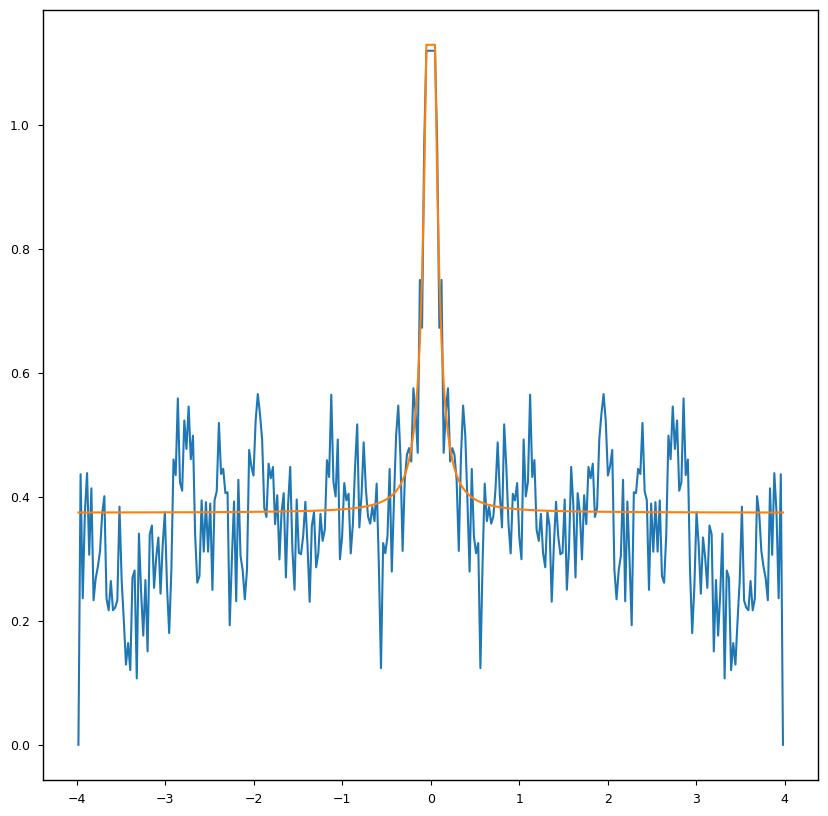

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2852.38it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 2.14530852
    reduced chi-square = 0.00890170
    Akaike info crit   = -1149.06790
    Bayesian info crit = -1138.57640
[[Variables]]
    gamma1:  0.06676097 +/- 0.00437710 (6.56%) (init = 0.2)
    m1:      1.10032500 +/- 0.03283385 (2.98%) (init = 1)
    c:       0.34029743 +/- 0.00392955 (1.15%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9373
    C(gamma1, c)  = -0.3260
    C(m1, c)      = +0.1894
None


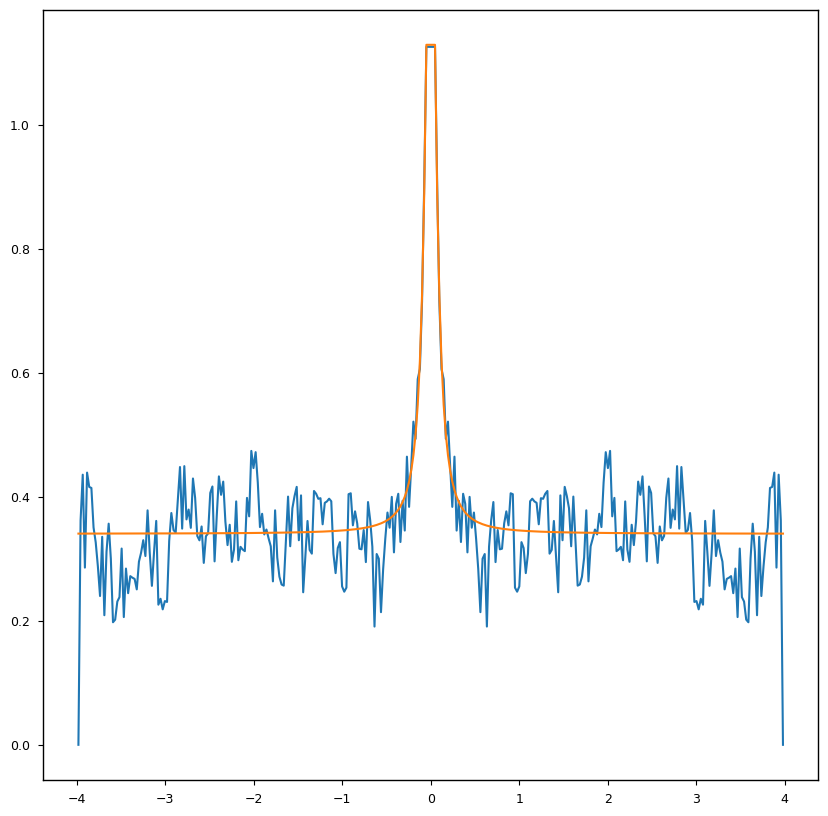

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2840.67it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 1.69016342
    reduced chi-square = 0.00701313
    Akaike info crit   = -1207.25169
    Bayesian info crit = -1196.76019
[[Variables]]
    gamma1:  0.05016545 +/- 0.00465736 (9.28%) (init = 0.2)
    m1:      1.10898438 +/- 0.05766727 (5.20%) (init = 1)
    c:       0.36375756 +/- 0.00339466 (0.93%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9737
    C(gamma1, c)  = -0.3145
    C(m1, c)      = +0.2335
None


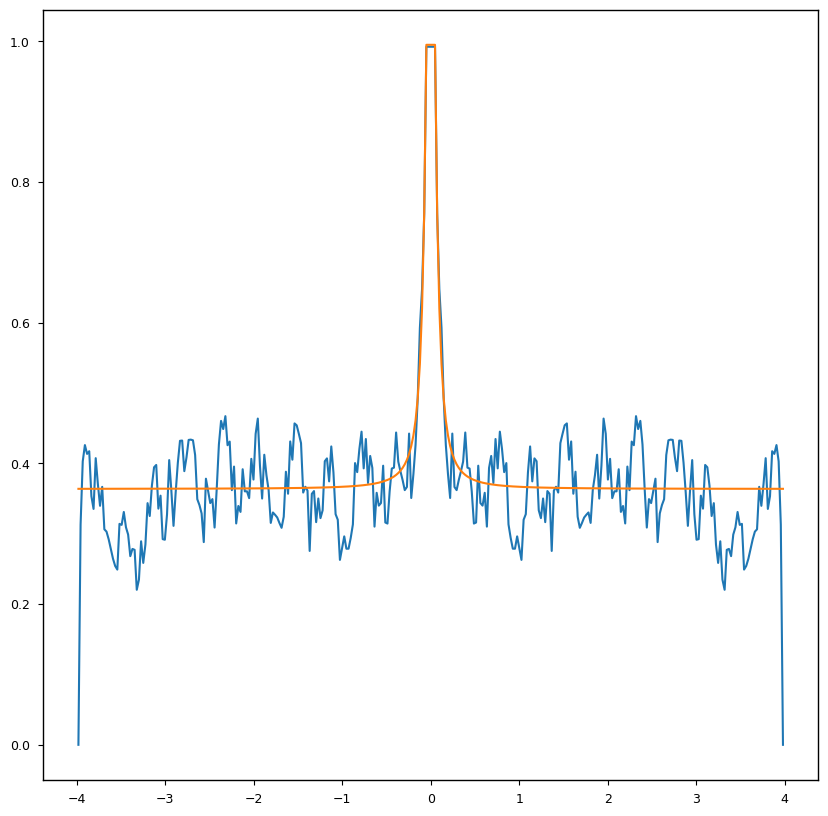

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2760.64it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 1.47569090
    reduced chi-square = 0.00612320
    Akaike info crit   = -1240.36223
    Bayesian info crit = -1229.87073
[[Variables]]
    gamma1:  0.05390902 +/- 0.00421776 (7.82%) (init = 0.2)
    m1:      1.09262790 +/- 0.04542896 (4.16%) (init = 1)
    c:       0.38121520 +/- 0.00327311 (0.86%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9667
    C(gamma1, c)  = -0.3194
    C(m1, c)      = +0.2251
None


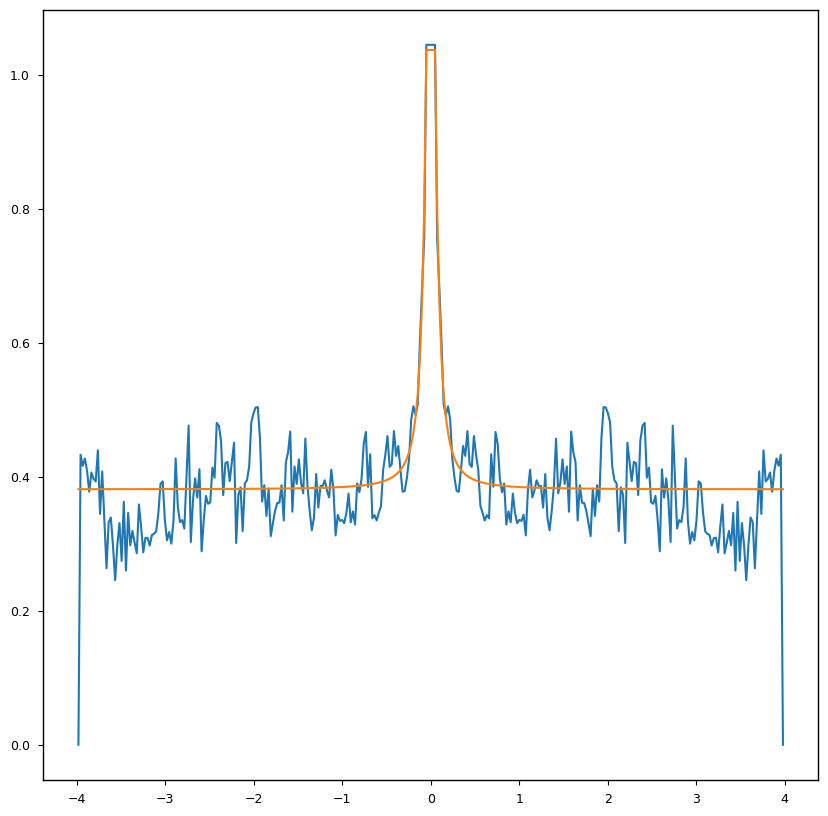

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2786.32it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 244
    # variables        = 3
    chi-square         = 1.52598092
    reduced chi-square = 0.00633187
    Akaike info crit   = -1232.18551
    Bayesian info crit = -1221.69401
[[Variables]]
    gamma1:  0.08128974 +/- 0.00534345 (6.57%) (init = 0.2)
    m1:      0.86792798 +/- 0.02320545 (2.67%) (init = 1)
    c:       0.38726081 +/- 0.00344387 (0.89%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.8954
    C(gamma1, c)  = -0.3509
    C(m1, c)      = +0.1518
None


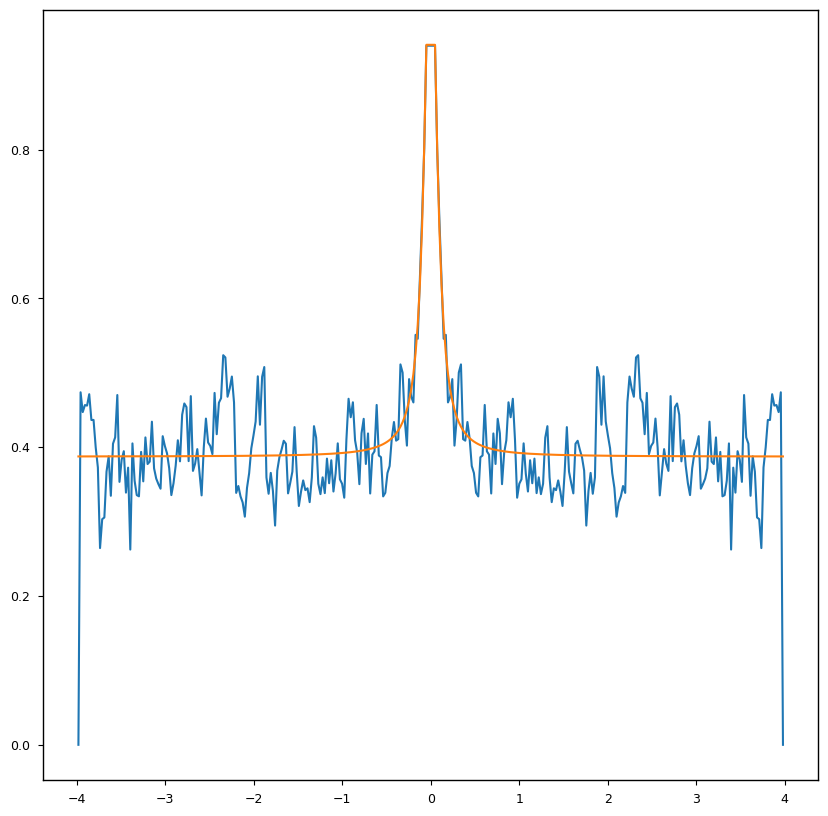

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2726.00it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 244
    # variables        = 3
    chi-square         = 2.45955576
    reduced chi-square = 0.01020563
    Akaike info crit   = -1115.71374
    Bayesian info crit = -1105.22224
[[Variables]]
    gamma1:  0.05052167 +/- 0.00715565 (14.16%) (init = 0.2)
    m1:      0.97038656 +/- 0.07695353 (7.93%) (init = 1)
    c:       0.40610367 +/- 0.00419029 (1.03%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9726
    C(gamma1, c)  = -0.3216
    C(m1, c)      = +0.2362
None


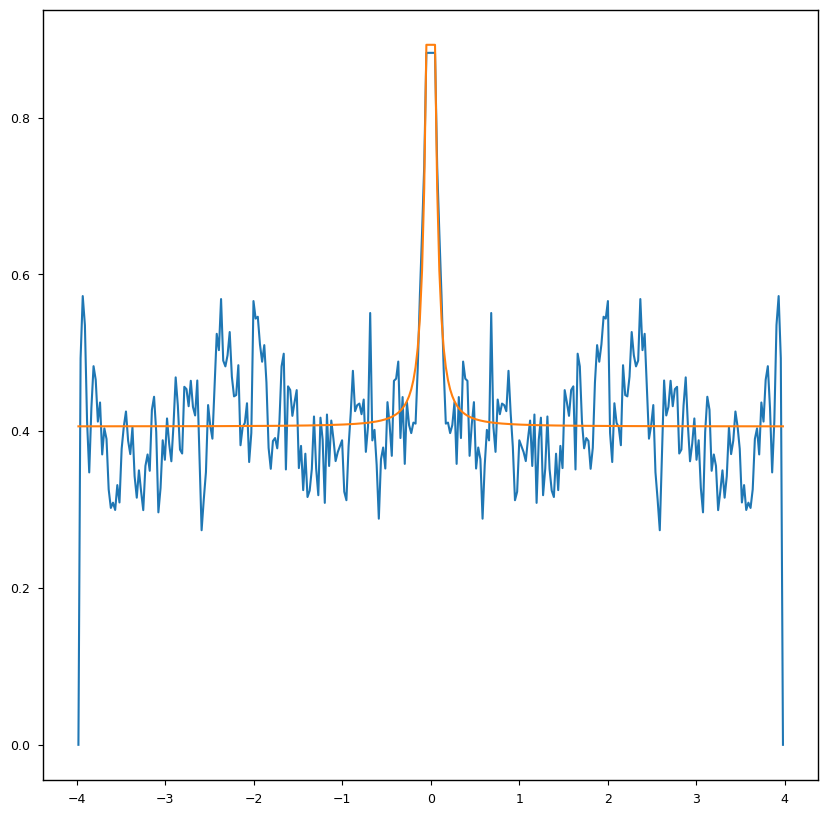

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2751.94it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 244
    # variables        = 3
    chi-square         = 1.62502851
    reduced chi-square = 0.00674286
    Akaike info crit   = -1216.84086
    Bayesian info crit = -1206.34935
[[Variables]]
    gamma1:  0.06749642 +/- 0.00537906 (7.97%) (init = 0.2)
    m1:      0.90038907 +/- 0.03308971 (3.68%) (init = 1)
    c:       0.36966537 +/- 0.00340142 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9341
    C(gamma1, c)  = -0.3351
    C(m1, c)      = +0.1894
None


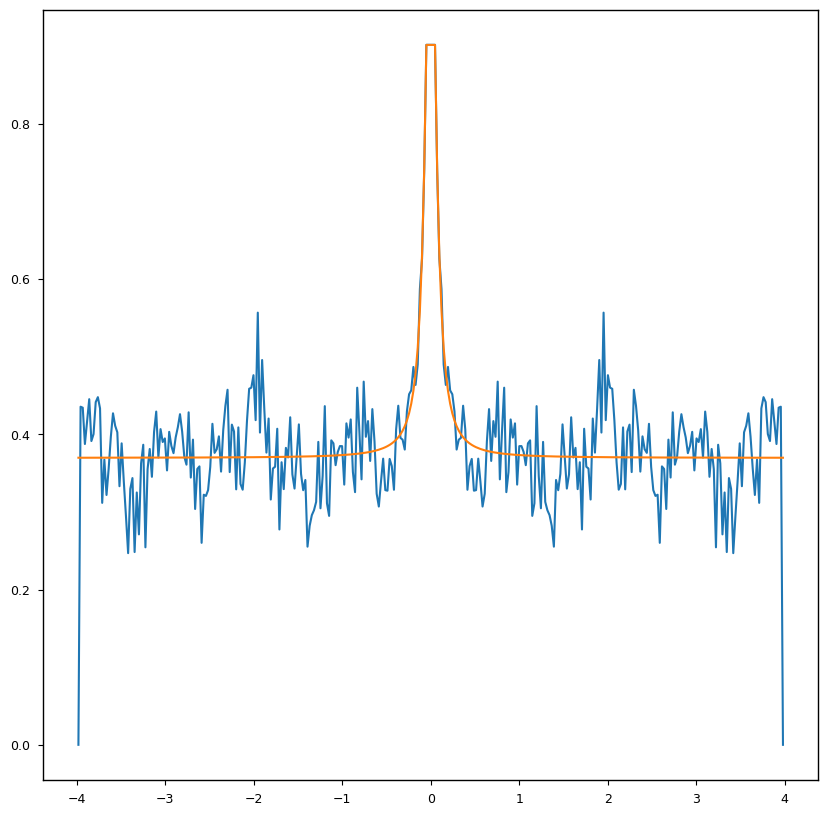

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2782.36it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 244
    # variables        = 3
    chi-square         = 1.74592891
    reduced chi-square = 0.00724452
    Akaike info crit   = -1199.33108
    Bayesian info crit = -1188.83958
[[Variables]]
    gamma1:  0.04735176 +/- 0.00534351 (11.28%) (init = 0.2)
    m1:      1.06765236 +/- 0.07045686 (6.60%) (init = 1)
    c:       0.36510001 +/- 0.00340958 (0.93%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9780
    C(gamma1, c)  = -0.3141
    C(m1, c)      = +0.2408
None


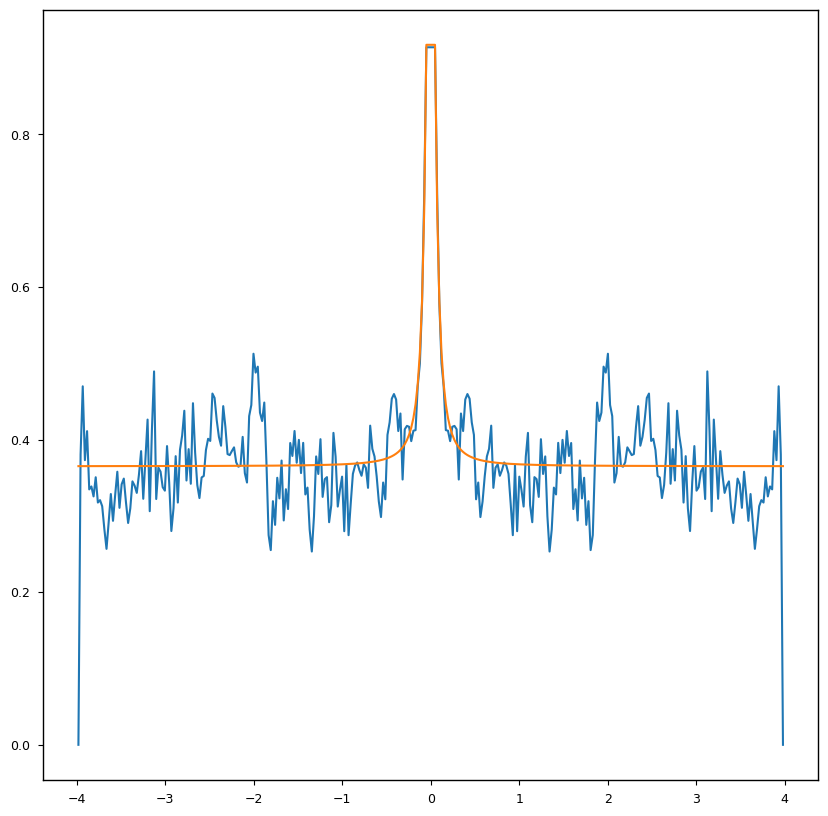

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2809.80it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 244
    # variables        = 3
    chi-square         = 1.99402022
    reduced chi-square = 0.00827394
    Akaike info crit   = -1166.91176
    Bayesian info crit = -1156.42026
[[Variables]]
    gamma1:  0.07870902 +/- 0.00553375 (7.03%) (init = 0.2)
    m1:      0.91881823 +/- 0.02669710 (2.91%) (init = 1)
    c:       0.36777784 +/- 0.00387860 (1.05%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9034
    C(gamma1, c)  = -0.3459
    C(m1, c)      = +0.1595
None


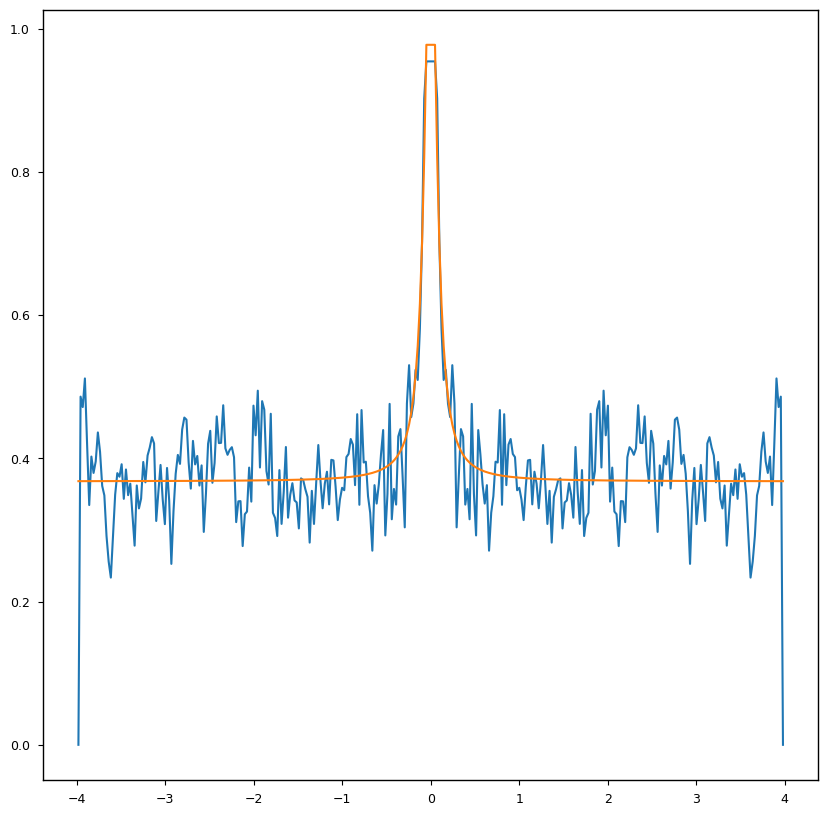

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 1877.56it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 3.04902536
    reduced chi-square = 0.01265156
    Akaike info crit   = -1063.29248
    Bayesian info crit = -1052.80098
[[Variables]]
    gamma1:  0.06457596 +/- 0.00700527 (10.85%) (init = 0.2)
    m1:      0.93973974 +/- 0.04818346 (5.13%) (init = 1)
    c:       0.38243351 +/- 0.00473730 (1.24%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9417
    C(gamma1, c)  = -0.3324
    C(m1, c)      = +0.1971
None


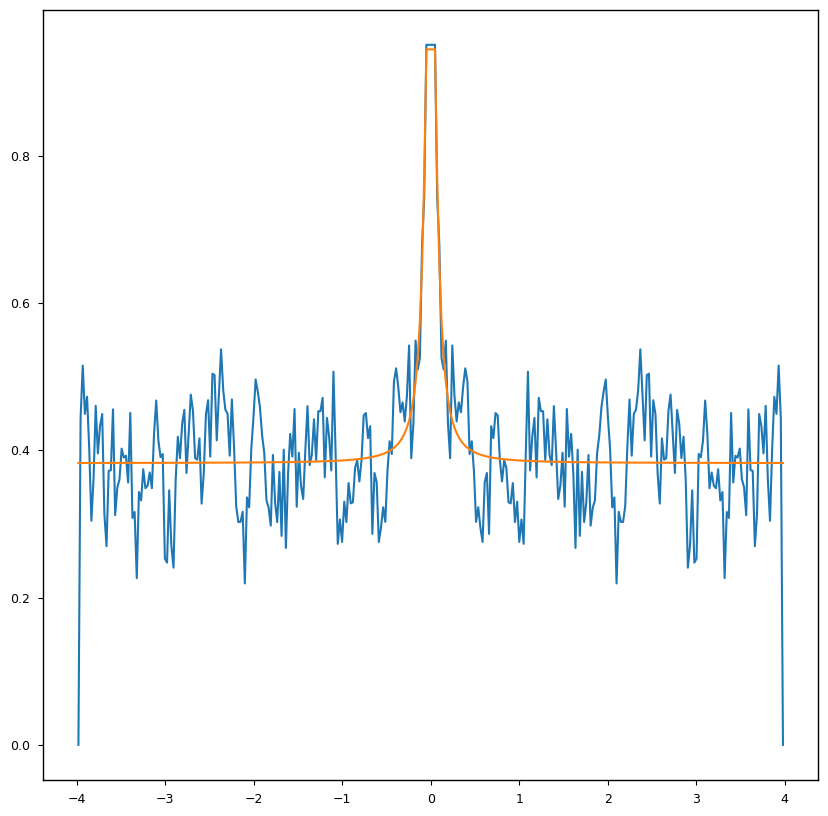

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2979.88it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 244
    # variables        = 3
    chi-square         = 3.03057019
    reduced chi-square = 0.01257498
    Akaike info crit   = -1064.77386
    Bayesian info crit = -1054.28235
[[Variables]]
    gamma1:  0.08051399 +/- 0.00701102 (8.71%) (init = 0.2)
    m1:      0.87925864 +/- 0.03213303 (3.65%) (init = 1)
    c:       0.28360859 +/- 0.00437572 (1.54%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.8979
    C(gamma1, c)  = -0.3418
    C(m1, c)      = +0.1526
None


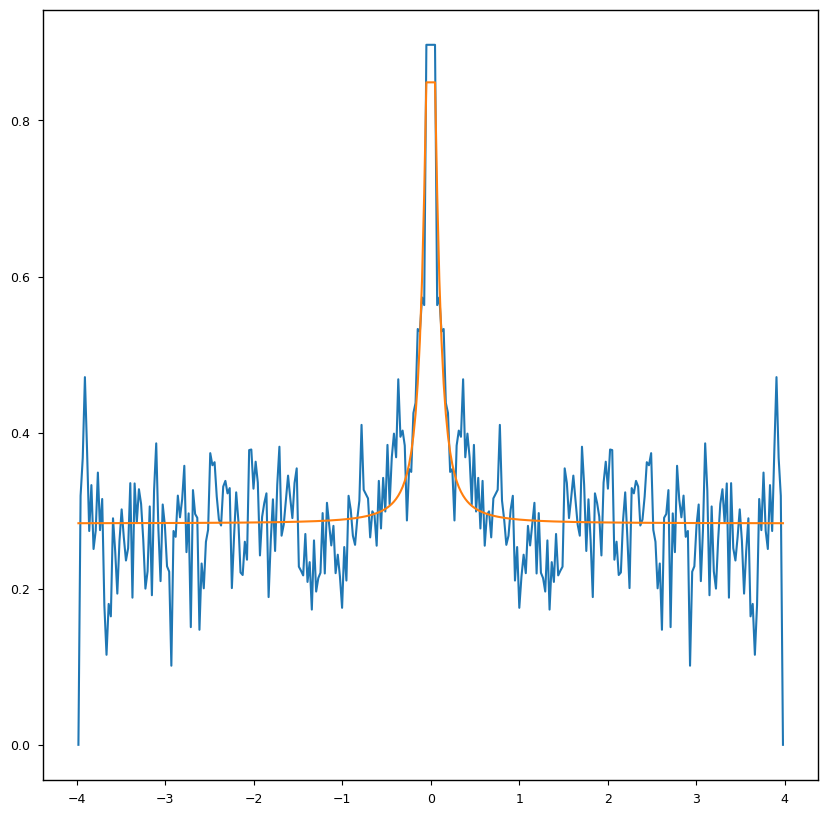

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2945.08it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 4.14477866
    reduced chi-square = 0.01719825
    Akaike info crit   = -988.377796
    Bayesian info crit = -977.886292
[[Variables]]
    gamma1:  0.05876519 +/- 0.00793632 (13.51%) (init = 0.2)
    m1:      0.96922070 +/- 0.06667626 (6.88%) (init = 1)
    c:       0.31236247 +/- 0.00511548 (1.64%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9553
    C(gamma1, c)  = -0.3238
    C(m1, c)      = +0.2122
None


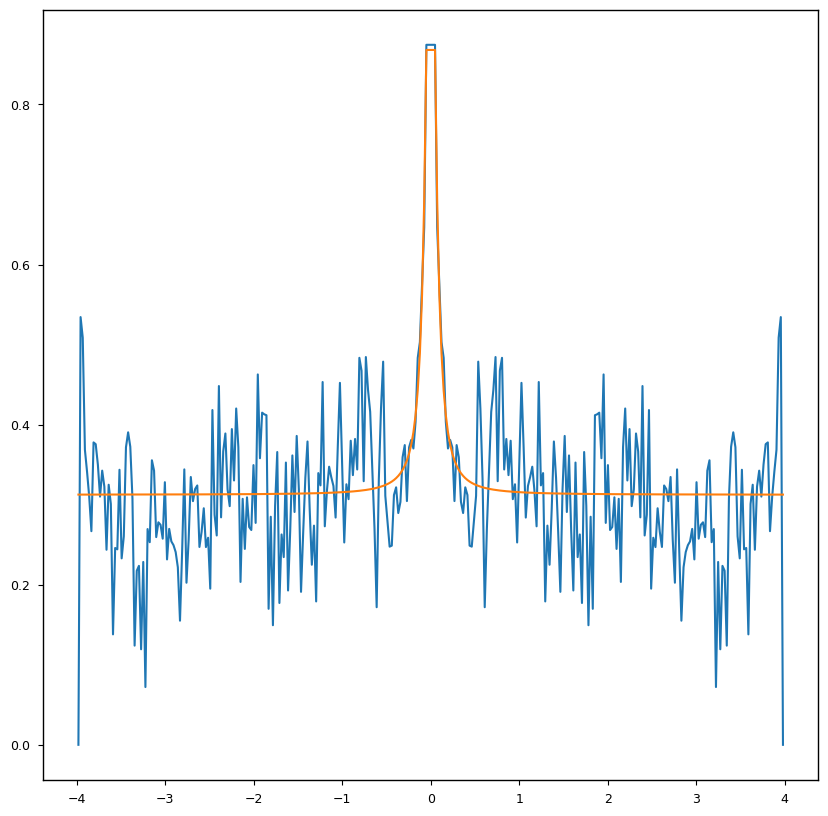

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2956.35it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 28.4395091
    reduced chi-square = 0.11800626
    Akaike info crit   = -518.450887
    Bayesian info crit = -507.959382
[[Variables]]
    gamma1:  0.05151556 +/- 0.01821327 (35.35%) (init = 0.2)
    m1:      1.09984499 +/- 0.21588378 (19.63%) (init = 1)
    c:       0.26779773 +/- 0.01304831 (4.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9704
    C(gamma1, c)  = -0.3109
    C(m1, c)      = +0.2261
None


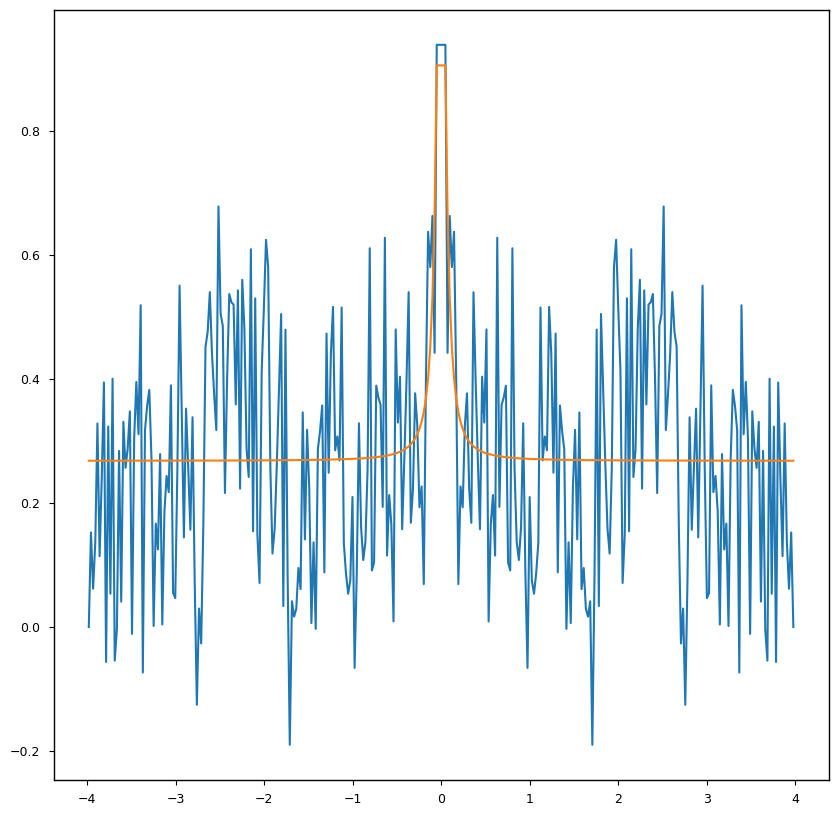

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2952.94it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 244
    # variables        = 3
    chi-square         = 103.758545
    reduced chi-square = 0.43053338
    Akaike info crit   = -202.644816
    Bayesian info crit = -192.153312
[[Variables]]
    gamma1:  0.07891857 +/- 0.02515277 (31.87%) (init = 0.2)
    m1:      1.19025934 +/- 0.15153905 (12.73%) (init = 1)
    c:       0.20931437 +/- 0.03177159 (15.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.8997
    C(gamma1, c)  = -0.3646
    C(m1, c)      = +0.1655
None


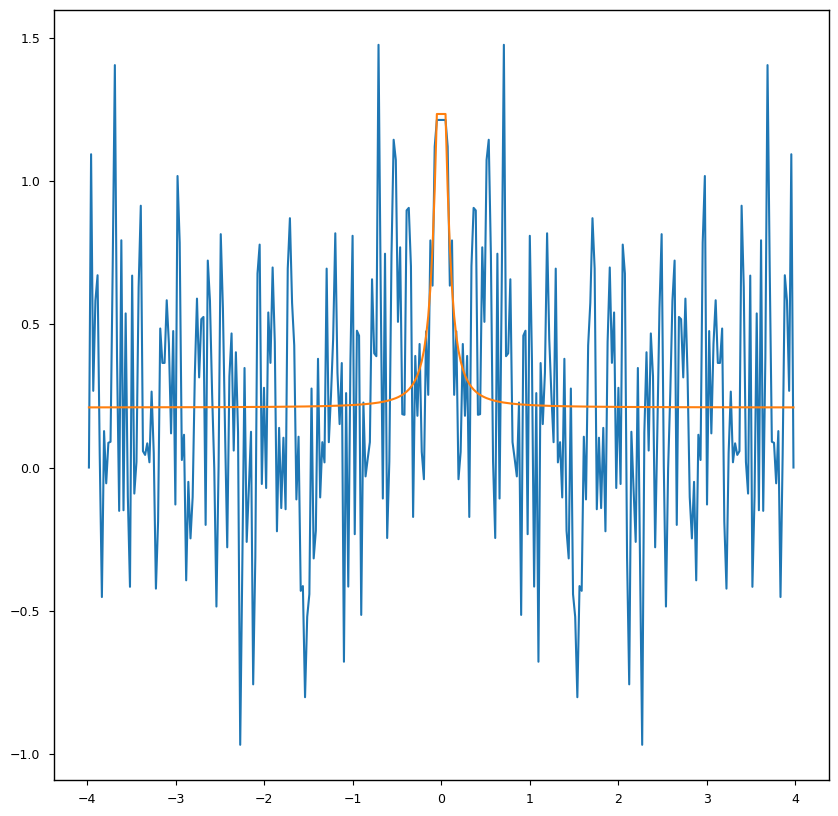

In [19]:
mods=[]
mod_uncert=[]
othermods=[]
othermod_uncert=[]
freq_scale_1=[]
freq_scale_1_uncert=[]
freq_scale_2=[]
mods_alternative = []
mods_alternative_uncert = []
for i in range(2500//2,2800//2,4):
    if prof_sn[i-2] > 8:
        spec_upchan = np.nanmean(I_upchan_corrected[:,i-2:i+2],axis=1)
        spec_upchan[np.isnan(spec_upchan)]=0
        spec_upchan=np.ma.masked_where(spec_upchan==0,spec_upchan)
        spec_fake = np.nanmean(I_upchan_corrected[:,1200:1204],axis=1)
        spec_fake[np.isnan(spec_fake)]=0
        spec_fake=np.ma.masked_where(spec_fake==0,spec_fake)
    
        acf_res = acf_scint_plot(spec_upchan,data_dedisp_derippled_masked_upchan_ds[2],data_dedisp_derippled_masked_upchan_ds[1],[0,0],lagrange_for_fit=0.01,diagnostic_plots=False,maxlag=4,offspec_mean=np.nanmean(spec_fake))
        plt.close()
    
        
        lagrange_for_fit=3
        f_res=0.39101/(fftsize//downfreq)

        acf=acf_res[0]
        lag=acf_res[1]
        acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
        lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
        #compute the ACF correlated errors
        acf_half = acf[len(acf)//2:]
        var_f = np.ones(len(acf_half)) / (len(acf_half))
        var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
        f_errors = np.sqrt(var_f)
        print("err",f_errors[0])
    
        f_errors_full = np.concatenate((f_errors[::-1],f_errors))
        acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
        
        # acf_fit = np.ma.masked_where(acf_fit==np.max(acf_fit),acf_fit)
        # acf = np.ma.masked_where(acf==np.max(acf),acf)
    
        params = Parameters()
        params.add('gamma1', value = 0.2, min= 0.00001, max = 100)
        params.add('m1', value = 1, min = -100, max = 100)
        #params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
        #params.add('m2', value = 1, min = -100, max = 100)
        params.add('c',value=0,min=-100,max=100)
    
        fit = Minimizer(lorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
        result_acf = fit.minimize()
        print(report_fit(result_acf))
    
        plt.plot(lag,acf)
        plt.plot(lag,lorentz_w_c(lag,result_acf.params['gamma1'],result_acf.params['m1'],result_acf.params['c']))
        plt.show()         
    

        mods.append(result_acf.params['m1'])
        mod_uncert.append(result_acf.params['m1'].stderr)
        #othermods.append(result_acf.params['m2'])
        #othermod_uncert.append(result_acf.params['m2'].stderr)
        freq_scale_1.append(result_acf.params['gamma1'])
        freq_scale_1_uncert.append(result_acf.params['gamma1'].stderr)
        #freq_scale_2.append(result_acf.params['gamma2'])
        mods_alternative.append(np.sqrt(np.max(acf_fit)-result_acf.params['c']))
        mods_alternative_uncert.append(np.sqrt(np.max(acf_fit)-result_acf.params['c']) * np.sqrt((f_errors[0]/np.max(acf_fit))**2 + (result_acf.params['c'].stderr/result_acf.params['c'])**2)/2.)
            
    else:
        mods.append(0)
        mod_uncert.append(0)
        othermods.append(0)
        othermod_uncert.append(0)
        freq_scale_1.append(0)
        freq_scale_1_uncert.append(0)
        freq_scale_2.append(0)
        mods_alternative.append(0)
        mods_alternative_uncert.append(0)
   


In [20]:
mod_uncert=np.array(mod_uncert)
mods=np.array(mods)
othermod_uncert=np.array(othermod_uncert)
othermods=np.array(othermods)
mods_alternative_uncert=np.array(mods_alternative_uncert)
mods_alternative=np.array(mods_alternative)

mods[np.isnan(mods)]=0
mods[mods==None]=0
mods=np.ma.masked_where(mods==0,mods)

othermods[np.isnan(othermods)]=0
othermods[othermods==None]=0
othermods=np.ma.masked_where(othermods==0,othermods)

mods_alternative[np.isnan(mods_alternative)]=0
mods_alternative[mods_alternative==None]=0
mods_alternative=np.ma.masked_where(mods_alternative==0,mods_alternative)

mod_uncert[mod_uncert=='nan']=0
mod_uncert[mod_uncert==None]=0
mod_uncert=np.ma.masked_where(mod_uncert==0,mod_uncert)

othermod_uncert[othermod_uncert=='nan']=0
othermod_uncert[othermod_uncert==None]=0
othermod_uncert=np.ma.masked_where(othermod_uncert==0,othermod_uncert)

mods_alternative_uncert[mods_alternative_uncert=='nan']=0
mods_alternative_uncert[mods_alternative_uncert==None]=0
mods_alternative_uncert=np.ma.masked_where(mods_alternative_uncert==0,mods_alternative_uncert)

mod_uncert=np.array([float(x) for x in np.array(mod_uncert)])
mods=np.array([float(x) for x in np.array(mods)])
othermod_uncert=np.array([float(x) for x in np.array(othermod_uncert)])
othermods=np.array([float(x) for x in np.array(othermods)])
mods_alternative_uncert=np.array([float(x) for x in np.array(mods_alternative_uncert)])
mods_alternative=np.array([float(x) for x in np.array(mods_alternative)])

/tmp/ipykernel_35/29985621.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mod_uncert[mod_uncert=='nan']=0
/tmp/ipykernel_35/29985621.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  othermod_uncert[othermod_uncert=='nan']=0
/tmp/ipykernel_35/29985621.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mods_alternative_uncert[mods_alternative_uncert=='nan']=0


In [21]:
freq_scale_1 = np.array(freq_scale_1)
freq_scale_1[np.isnan(freq_scale_1)]=0
freq_scale_1[freq_scale_1==None]=0
freq_scale_1=np.ma.masked_where(freq_scale_1==0,freq_scale_1)
freq_scale_1_uncert = np.array(freq_scale_1_uncert)
freq_scale_1_uncert[freq_scale_1_uncert=='nan']=100
freq_scale_1_uncert[freq_scale_1_uncert==None]=100
freq_scale_1_uncert=np.ma.masked_where(freq_scale_1_uncert==0,freq_scale_1_uncert)

freq_scale_2 = np.array(freq_scale_2)
freq_scale_2[np.isnan(freq_scale_2)]=0
freq_scale_2[freq_scale_2==None]=0
freq_scale_2=np.ma.masked_where(freq_scale_2==0,freq_scale_2)

/tmp/ipykernel_35/3244498441.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  freq_scale_1_uncert[freq_scale_1_uncert=='nan']=100


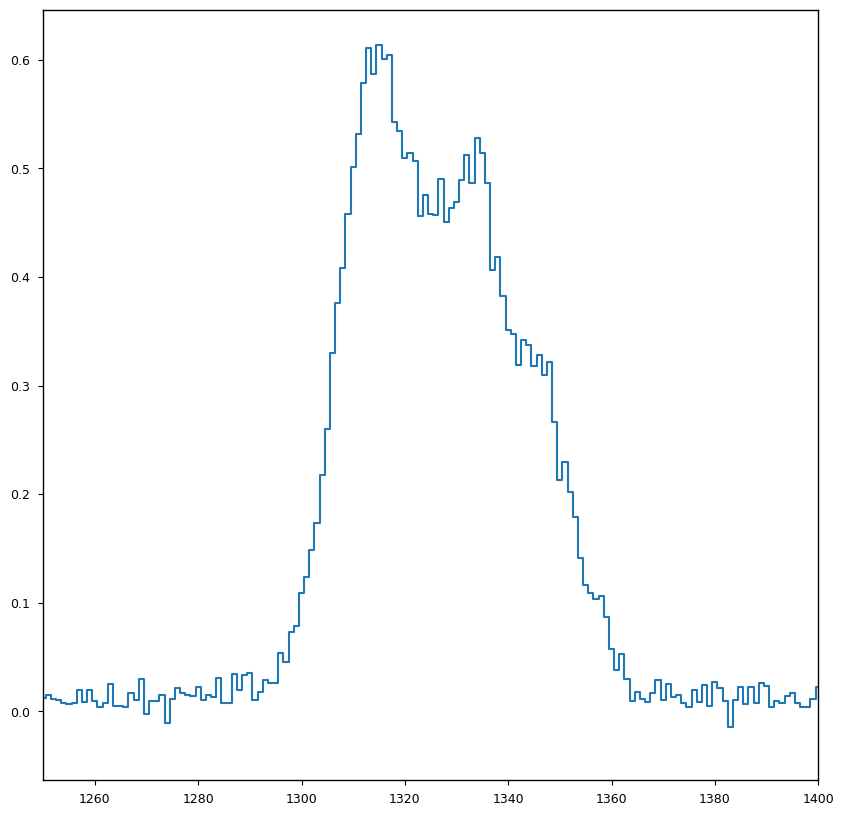

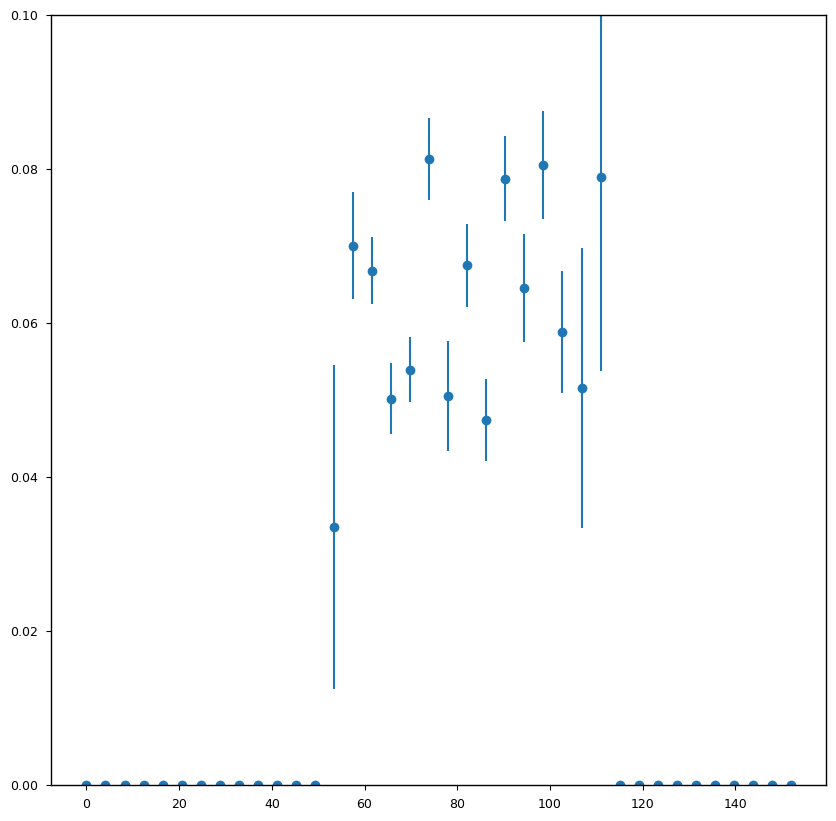

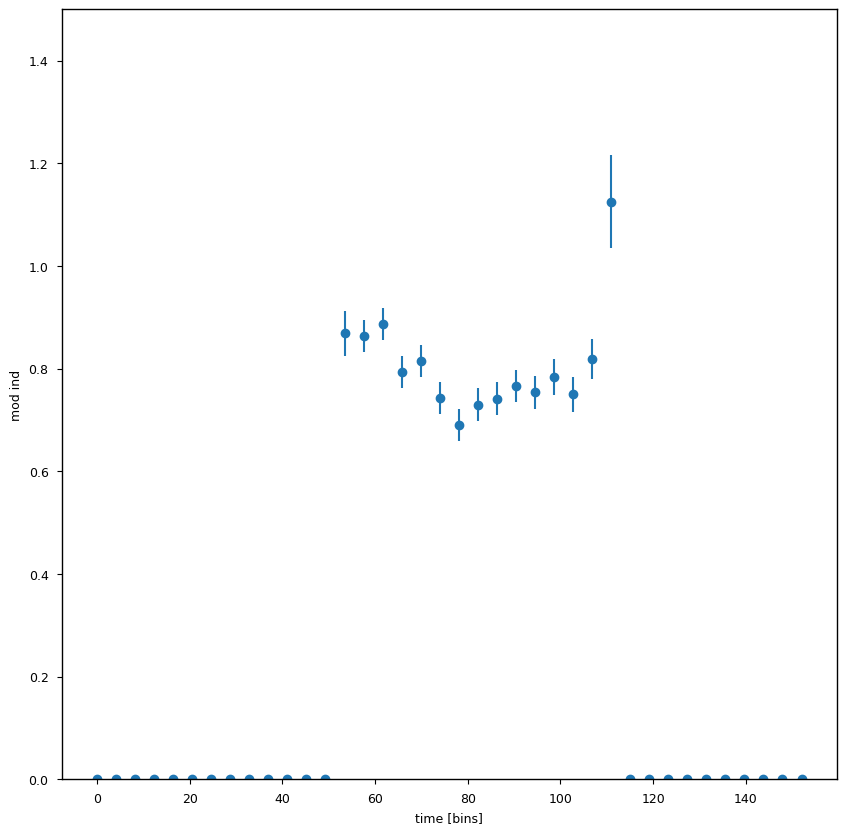

In [22]:
plt.plot(np.nanmean(I_upchan_corrected,axis=0), drawstyle='steps-mid')
plt.xlim(2500//2,2800//2)
plt.show()


plt.errorbar(np.linspace(0,len(mods)*4,len(mods)), np.array(np.abs(freq_scale_1)), yerr=np.array(freq_scale_1_uncert),linestyle='none',marker='o')
plt.ylim(0,0.1)
plt.show()
# plt.errorbar(np.linspace(0,len(mods)*4,len(mods)),mods,yerr=mod_uncert, linestyle='none',marker='o')
# plt.ylim(0,1.5)
# plt.xlabel('time [bins]')
# plt.ylabel('mod ind')
# plt.show()

plt.errorbar(np.linspace(0,len(mods_alternative)*4,len(mods_alternative)),mods_alternative,yerr=np.array(mods_alternative_uncert),linestyle='none',marker='o')
plt.ylim(0,1.5)
plt.xlabel('time [bins]')
plt.ylabel('mod ind')
plt.show()

## Rise and decay time

In [23]:
#From Utgarsh
def profile(dm, t0, width, fluence, ns, alphas, tau):


        lfreq = np.log(upsampled_frequency()/constants.FREQ_BOTTOM_MHZ)
        lamp_fact = ns[:,None,None] * lfreq[None, :, :] + alphas[:,None,None] * lfreq[None,:,:] ** 2
        amp = (10**fluence[:,None, None]) * np.exp(lamp_fact)
        delay = (constants.K_DM * 1e-6) * dm[:, None, None] * (((upsampled_frequency()[None,:,:] / 1e3) ** -2.) - (constants.FREQ_BOTTOM_MHZ / 1e3) ** (-2)) + t0[:,None, None]


        scatter = (tau[:,None, None]) * (upsampled_frequency()[None,:,:] / 600.) ** (-4.)
        time = upsampled_times()[None, :, :, None, :] - delay[:, :, None, :, None]
        scatter = scatter[:, :, None, :, None]
        width = width[:,None, None, None, None]
        condition = scatter < -100
        norm = 1.0 / (width * np.sqrt(2.0 * np.pi))
        arg = -time ** 2 /  2 / width ** 2

        out1 = np.exp(arg) * norm
        time = np.where(time < -5 * width, -5 * width, time)
        norm = 1.0 / 2 / scatter
        norm = norm * np.exp(width ** 2 / 2 / scatter ** 2)
        erfcarg = (width / np.sqrt(2) / scatter) - time / (np.sqrt(2) * width)
        out2 = (norm * np.exp(-time / scatter) * scipy.special.erfc(erfcarg))

        out = np.where(condition, out1, out2)
        out = np.mean(out, (-1))
        out = np.mean(amp[:,:,None,:]*out, (-1))
        out = np.sum(out, 0)
        return out
    
def upsample(array, delta, factor=1):
    diff = ((np.arange(np.array(factor, int), dtype=np.float64) + 0.5 ) / factor - 0.5) * delta
    out = array.reshape(-1,)[:, None] + diff[None, :]
    return out.reshape((array.shape) + (factor,))

def upsampled_frequency(factor=1):
    delta = np.median(np.abs(np.diff(frequency)))
    return upsample(frequency, delta, factor=factor)

def upsampled_times(factor=1):
        near_times = get_times()
        delta = np.median(np.abs(np.diff(dataset_times)))
        return upsample(near_times, delta, factor=factor)
    
def get_times():
    return np.array([dataset_times[0:intensity.shape[1]] for i in range(len(frequency))])

In [24]:
datamodel = DataModel(247411829)
intensity = datamodel.intensity
frequency = datamodel.frequency
dataset_times = datamodel.dataset_times

In [25]:
mcmc_samples = np.load('247411829_ScatteredBurstModel_2023-11-25_03:24:05.npy', allow_pickle=True).item()
num_components=3
handle = np.load(f'fitburst_input_247411829.npz', allow_pickle=True)
chans = np.arange(1024)
chans = np.delete(chans, handle['metadata'].item()['bad_chans'])

In [26]:
dictionary = {}
for i in range(num_components):
    
    dictionary[f'profile{i}'] = profile(*(np.array([x]) for x in [np.mean(mcmc_samples['dm'][-300:], 0), 
        np.mean(mcmc_samples[f't0{i}'][-300:], 0), 
        (np.mean(mcmc_samples[f'width{i}'][-300:], 0)), 
        np.log10(np.mean(mcmc_samples[f'fluence{i}'][-300:], 0)), 
        np.mean(mcmc_samples[f'ns{i}'][-300:], 0),
        np.mean(mcmc_samples[f'alphas{i}'][-300:], 0),
        np.mean(mcmc_samples[f'tau0'][-300:], 0)]))
    

profile0 = dictionary['profile0']
profile1 = dictionary['profile1']
profile2 = dictionary['profile2']

profile = profile0 + profile1 + profile2

In [27]:
power = np.abs(data**2)
I = np.sum(power,axis=1)


In [28]:
I_corrected = np.zeros_like(I)
    
for freq_chan in range(I_corrected.shape[0]):
    Ioff=np.copy(I[freq_chan,:15000])
    I_corrected[freq_chan,:] = I[freq_chan,:] - np.nanmean(Ioff)
    Ioff-=np.nanmean(Ioff)
    I_corrected[freq_chan,:] = I_corrected[freq_chan,:] / np.nanstd(Ioff)

In [29]:
prof=np.copy(np.nanmean(I_corrected,axis=0))
offprof = prof[:15000]
prof-=np.nanmean(offprof)
offprof-=np.nanmean(offprof)
prof/=np.nanstd(offprof)

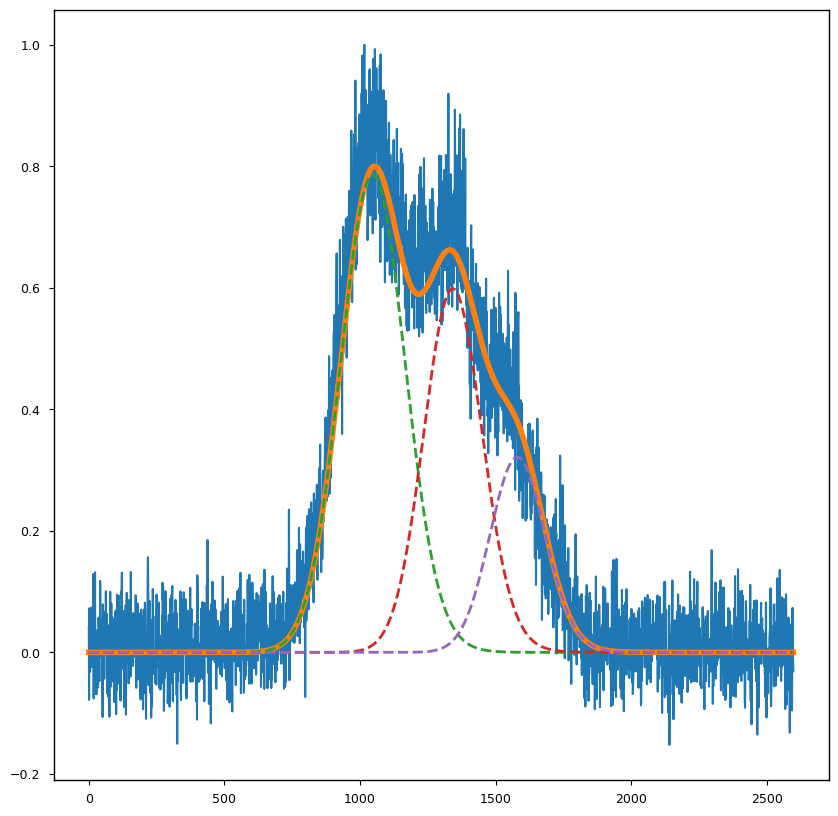

In [30]:
plt.plot(prof[20000:20000+len(handle['data_full'][chans].sum(0))]/np.max(prof))
plt.plot(profile[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, label='model', lw=4)
plt.plot(profile0[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, ls='--', lw=2, label=r'$1^{\mathrm{st}}$ component')
plt.plot(profile1[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, ls='--', lw=2, label=r'$2^{\mathrm{nd}}$ component')
plt.plot(profile2[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, ls='--', lw=2, label=r'$3^{\mathrm{rd}}$ component')

In [31]:
prof_8=np.nanmean(I_upchan_corrected,axis=0)
offprof = prof_8[:1000]
prof_8-=np.nanmean(offprof)
offprof-=np.nanmean(offprof)
prof_8/=np.nanstd(offprof)

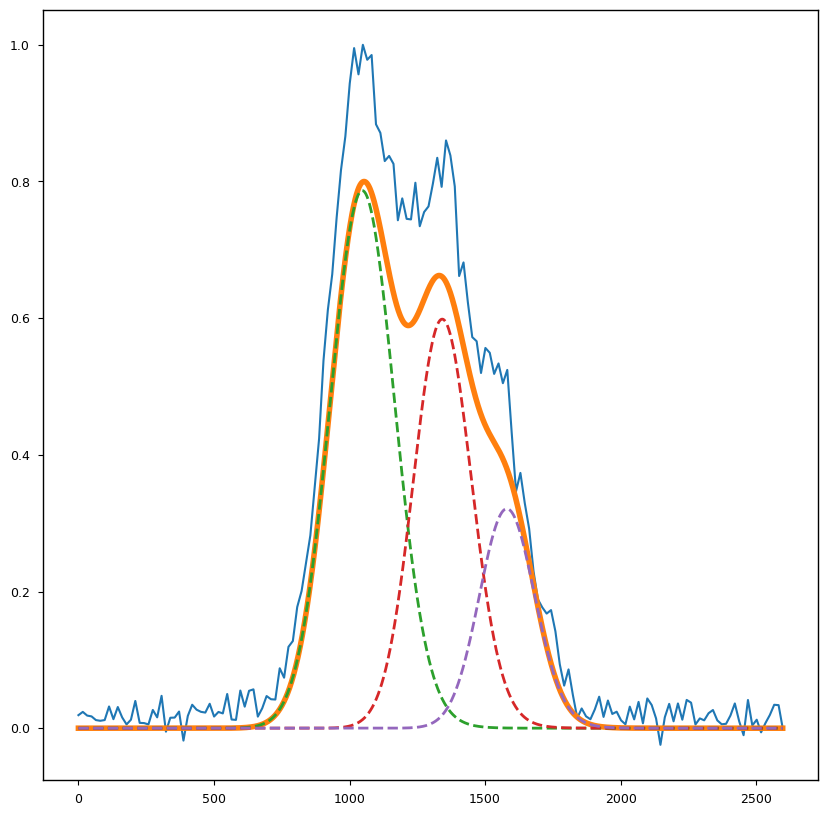

In [32]:
plt.plot(np.linspace(0,len(profile[chans].sum(0)),len(prof_8[20000//16:(20000+len(handle['data_full'][chans].sum(0)))//16])),prof_8[20000//16:(20000+len(handle['data_full'][chans].sum(0)))//16]/np.max(prof_8))

plt.plot(profile[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, label='model', lw=4)
plt.plot(profile0[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, ls='--', lw=2, label=r'$1^{\mathrm{st}}$ component')
plt.plot(profile1[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, ls='--', lw=2, label=r'$2^{\mathrm{nd}}$ component')
plt.plot(profile2[chans].sum(0)/np.max(profile[chans].sum(0))*0.8, ls='--', lw=2, label=r'$3^{\mathrm{rd}}$ component')

In [33]:
offstats=prof_8[0:20000//16]/np.max(prof_8)
off_std = np.nanstd(offstats)
first_comp_peak = np.argmax(profile0[chans].sum(0))
third_comp_peak = np.argmax(profile2[chans].sum(0))
first_comp_begin = np.where(profile0[chans].sum(0)[:first_comp_peak]/np.max(prof_8)<off_std)[0][-1]
third_comp_end = np.where(profile2[chans].sum(0)[third_comp_peak:]/np.max(prof_8)<off_std)[0][0] + third_comp_peak

In [34]:
cropped_prof=prof_8[20000//16:(20000+len(handle['data_full'][chans].sum(0)))//16]
first_comp_begin=int(first_comp_begin//16)
first_comp_peak=int(first_comp_peak//16)
third_comp_end=int(third_comp_end//16)
third_comp_peak=int(third_comp_peak//16)

In [35]:
#now we want to compute where the flux falls to 90%
first_area=np.nansum(cropped_prof[first_comp_begin:first_comp_peak])
third_area=np.nansum(cropped_prof[third_comp_peak:third_comp_end])

first_areas=[]
for i in range(first_comp_peak-first_comp_begin):
    if i==0:
        first_areas.append(0)
    else:
        first_areas.append(np.nansum(cropped_prof[first_comp_peak-i:first_comp_peak]))
        
third_areas=[]
for i in range(third_comp_end-third_comp_peak):
    if i==0:
        third_areas.append(0)
    else:
        third_areas.append(np.nansum(cropped_prof[third_comp_peak:third_comp_peak+i]))
        
        

In [36]:
rise_begin = first_comp_peak - np.where(first_areas/first_area < 0.9)[0][-1] 
fall_end = third_comp_peak + np.where(third_areas/third_area < 0.9)[0][-1]

rise time 532.48 us
fall time 491.52 us
rise/decay 1.0833333333333333


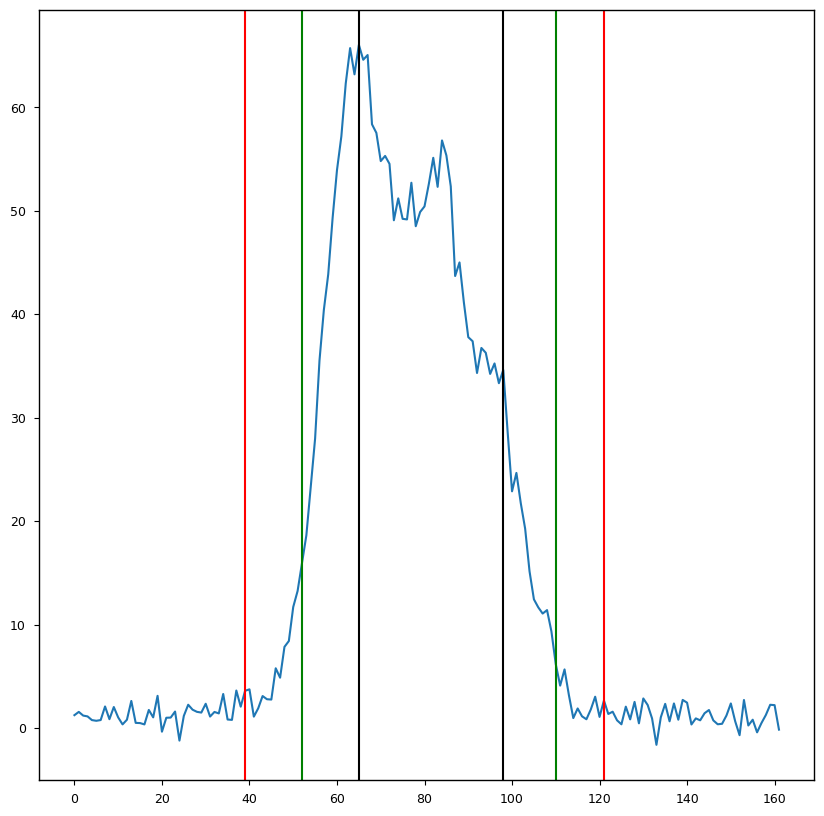

In [37]:
plt.plot(cropped_prof)
plt.axvline(first_comp_begin,color='r')
plt.axvline(first_comp_peak,color='k')
plt.axvline(third_comp_end,color='r')
plt.axvline(third_comp_peak,color='k')
plt.axvline(rise_begin,color='g')
plt.axvline(fall_end,color='g')

print("rise time",(first_comp_peak-rise_begin)*2.56*16,"us")
print("fall time",(fall_end - third_comp_peak)*2.56*16,"us")
print("rise/decay", (first_comp_peak-rise_begin)/(fall_end - third_comp_peak))

# PLOT THE DYNAMIC SPECTRUM PLOT

In [38]:
#downsample in freq
Iscr = scrunch(I_upchan_corrected,tscrunch=1,fscrunch=256)

In [39]:
#normalise the prof and spec for plotting
prof=np.nanmean(Iscr,axis=0)
offprof = prof[:2000//2]
prof-=np.nanmean(offprof)
offprof-=np.nanmean(offprof)
prof/=np.nanstd(offprof)

spec_plot = np.nanmean(Iscr[:,2600//2:2715//2],axis=1)
offspec = np.nanmean(Iscr[:,:2000//2],axis=1)

spec_plot-=np.nanmean(offspec)
offspec-=np.nanmean(offspec)
spec_plot/=np.nanstd(offspec)
offspec/=np.nanstd(offspec)

/tmp/ipykernel_35/2649261142.py:8: RuntimeWarning: Mean of empty slice
  spec_plot = np.nanmean(Iscr[:,2600//2:2715//2],axis=1)
/tmp/ipykernel_35/2649261142.py:9: RuntimeWarning: Mean of empty slice
  offspec = np.nanmean(Iscr[:,:2000//2],axis=1)


In [40]:
mods=mods_alternative
mod_uncert=mods_alternative_uncert

(0.0, 10.0)

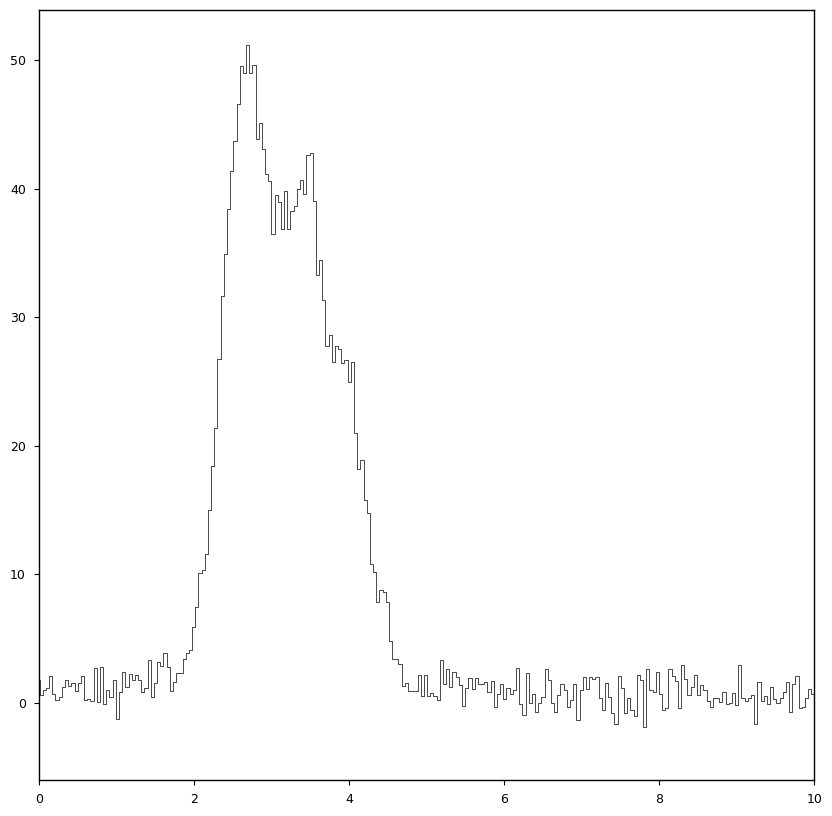

In [41]:
plt.plot(np.linspace(-1250*2.56e-3*4*2*2,(Iscr.shape[1]-1250)*2.56e-3*4*2*2,Iscr.shape[1]),prof,color='k',drawstyle='steps-mid',lw=0.5)
plt.xlim(0,10)

In [42]:
print(len(mods))

print(len(prof))

38
2000


modulation index weighted average: 0.7856212640577266+-0.06463973984344774


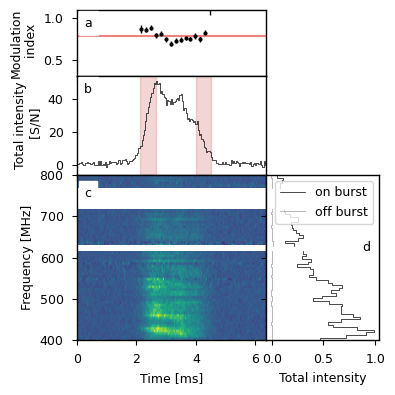

In [46]:
df = 400. / 1024
all_freqs = np.linspace(800., 400., Iscr.shape[0])
rows = 3
cols = 2
fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(ncols=cols, nrows=rows, width_ratios=[1,0.6], height_ratios=[0.4,0.6,1], wspace=0, hspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax1.errorbar(np.linspace((2500-2500)*2.56e-3*4*2*2,(2800//2-2500//2)*2.56e-3*4*2*2,len(mods)),mods,yerr=mod_uncert,marker='o',color='k',linestyle='None',markersize=2,lw=1)
mod_avg = np.average(mods[mods!=0],weights=1./(mod_uncert[mods!=0])**2)
mod_variance = np.average((mods[mods!=0]-mod_avg)**2, weights=1./(mod_uncert[mods!=0])**2)
print("modulation index weighted average:", str(mod_avg)+"+-"+str(np.sqrt(mod_variance)))
ax1.axhline(mod_avg,color='lightcoral')
plt.setp(ax1.get_xticklabels(), visible=False)
t=ax1.text(.04, .9, 'a', ha='left', va='top', transform=ax1.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
ax2.axvspan(rise_begin*2.56e-3*4*2*2,first_comp_peak*2.56e-3*4*2*2,color='indianred',alpha=0.25)
ax2.axvspan(third_comp_peak*2.56e-3*4*2*2,fall_end*2.56e-3*4*2*2,color='indianred',alpha=0.25)
ax2.plot(np.linspace(-1250*2.56e-3*4*2*2,(Iscr.shape[1]-1250)*2.56e-3*4*2*2,Iscr.shape[1]),prof,color='k',drawstyle='steps-mid',lw=0.5)
plt.setp(ax2.get_xticklabels(), visible=False)
t=ax2.text(.04, .93, 'b', ha='left', va='top', transform=ax2.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax3 = fig.add_subplot(gs[2,0],sharex=ax2)
ax3.imshow(Iscr,aspect='auto',extent=[-1250*2.56e-3*4*2*2,(Iscr.shape[1]-1250)*2.56e-3*4*2*2,all_freqs[-1]- df/2., all_freqs[0]+ df/2.])
t=ax3.text(.04, .93, 'c', ha='left', va='top', transform=ax3.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


ax4 = fig.add_subplot(gs[2,1],sharey=ax3)
ax4.plot(spec_plot/np.nanmax(spec_plot),all_freqs,color='k',drawstyle='steps-mid',label='on burst',lw=0.5)
ax4.plot(offspec/np.nanmax(spec_plot),all_freqs,color='k',alpha=0.4,drawstyle='steps-mid',label='off burst',lw=0.5)
ax4.legend(loc='upper right')
plt.setp(ax4.get_yticklabels(), visible=False)
t=ax4.text(.85, .6, 'd', ha='left', va='top', transform=ax4.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax1.set_xlim(0,155*2.56e-3*16)
ax1.set_ylim(0.3,1.1)
ax3.set_ylim(400,800)
ax1.set_ylabel('Modulation\n index')
ax2.set_ylabel('Total intensity\n [S/N]')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel('Frequency [MHz]')
ax4.set_xlabel('Total intensity')

fig.tight_layout(pad=1)
plt.savefig('./PA_swing_burst_ds.rev.jpg',format='jpg',dpi=300)
plt.show()

# Figure showing the upchannelisation process and the artefacts introduced

/opt/pysetup/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(20000.0, 23000.0)

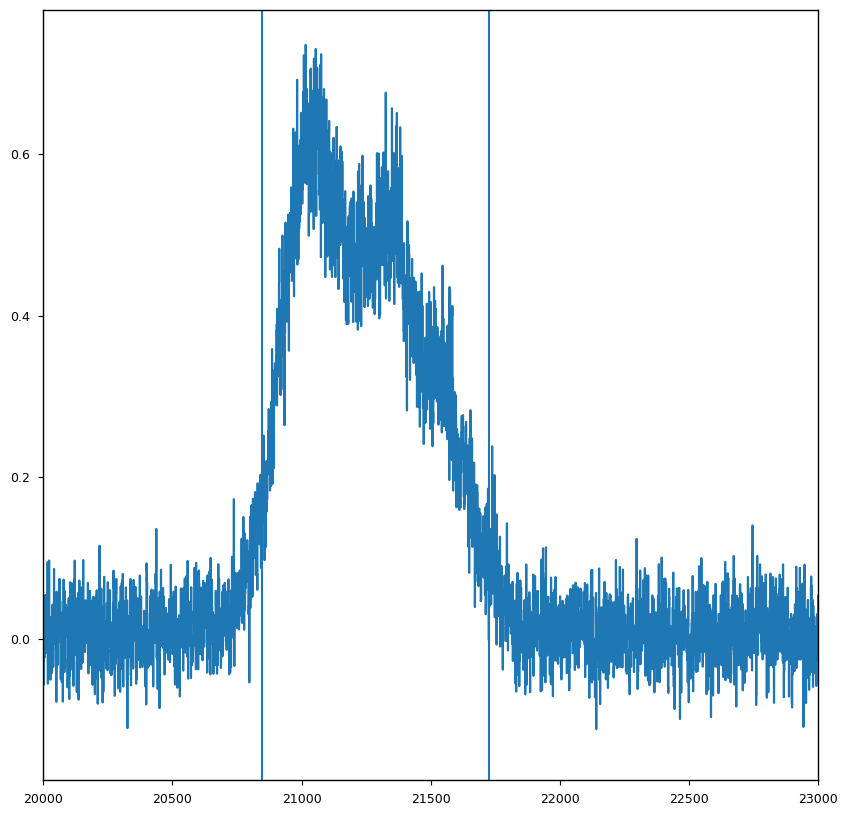

In [47]:
plt.plot(np.nanmean(I_corrected,axis=0), drawstyle='steps-mid')
st_tbin, end_tbin = get_main_peak_lim(I_corrected,diagnostic_plots=False,normalize_profile=True)
lim=np.array([st_tbin, end_tbin])
plt.axvline(lim[0]+50)
plt.axvline(lim[1])
plt.xlim(20000,23000)

In [48]:
#no upchannelisation
spec = np.nanmean(I_corrected[:,lim[0]+50:lim[1]],axis=1)
offspec=np.nanmean(I_corrected[:,0:15000],axis=1)

In [49]:
#upchan
fftsize=512
downfreq=1
data_dedisp_derippled_masked_upchan_512 = upchan(data,freqid,fftsize=fftsize,downfreq=downfreq)
#upchannel the noise to model the scalloping
noise_dedisp_derippled_masked_upchan_512 = upchan(data_fake,freqid_fake,fftsize=fftsize,downfreq=downfreq)

model_512, off_corrected_spec_512, inds_512 = make_scallop_model(noise_dedisp_derippled_masked_upchan_512[0], fftsize, downfreq)

(35.0, 45.0)

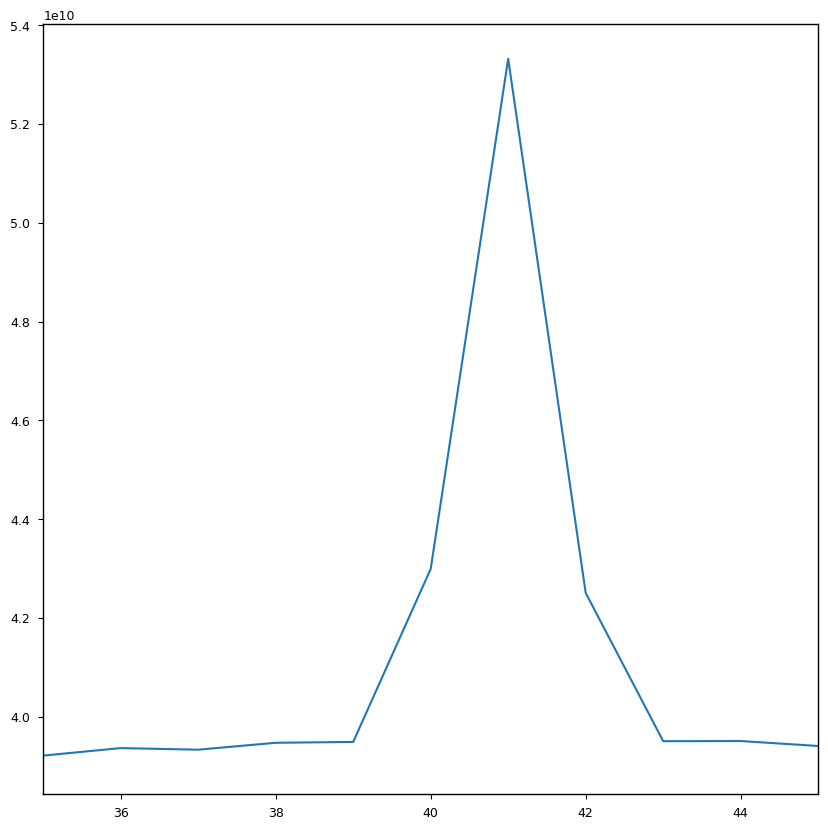

In [50]:
power_512 = np.abs(data_dedisp_derippled_masked_upchan_512[0]**2)
I_512 = np.sum(power_512,axis=0).T
plt.close('all')
plt.plot(np.nanmean(I_512,axis=0))
plt.xlim(35,45)

In [51]:
#uncorrected upchan
spec_upchan=np.nanmean(I_512[:,41:42],axis=1)
spec_upchan[np.isnan(spec_upchan)]=0
spec_upchan[inds_512]=0
spec_upchan=np.ma.masked_where(spec_upchan==0,spec_upchan)

spec_fake_upchan = np.nanmean(I_512[:,0:20],axis=1)
spec_fake_upchan[np.isnan(spec_fake_upchan)]=0
#spec_fake_upchan[inds_512]=0
spec_fake_upchan=np.ma.masked_where(spec_fake_upchan==0,spec_fake_upchan)

In [52]:
#per channel I want to remove the scalloping and normalise using off burst data
I_512upchan_corrected = np.zeros_like(I_512)
for time_bin in range(I_512.shape[1]):
    I_512upchan_corrected[:,time_bin] = I_512[:,time_bin]/model_512
    
    
for freq_chan in range(I_512upchan_corrected.shape[0]):
    Ioff=I_512upchan_corrected[freq_chan,:30]
    I_512upchan_corrected[freq_chan,:] = I_512upchan_corrected[freq_chan,:] - np.nanmean(Ioff)
    Ioff-=np.nanmean(Ioff)
    I_512upchan_corrected[freq_chan,:] = I_512upchan_corrected[freq_chan,:] / np.nanstd(Ioff)
    

In [53]:
spec_upchan_corr=np.nanmean(I_512upchan_corrected[:,41:42],axis=1)
spec_upchan_corr[np.isnan(spec_upchan_corr)]=0
spec_upchan_corr[inds_512]=0
spec_upchan_corr=np.ma.masked_where(spec_upchan_corr==0,spec_upchan_corr)

spec_fake_upchan_corr = np.nanmean(I_512upchan_corrected[:,0:5],axis=1)
spec_fake_upchan_corr[np.isnan(spec_fake_upchan_corr)]=0
spec_fake_upchan_corr[inds_512]=0
spec_fake_upchan_corr=np.ma.masked_where(spec_fake_upchan_corr==0,spec_fake_upchan_corr)

spec_fake_upchan_corr2 = np.nanmean(I_512upchan_corrected[:,10:11],axis=1)
spec_fake_upchan_corr2[np.isnan(spec_fake_upchan_corr2)]=0
spec_fake_upchan_corr2[inds_512]=0
spec_fake_upchan_corr2=np.ma.masked_where(spec_fake_upchan_corr2==0,spec_fake_upchan_corr2)

calib_off=spec_fake_upchan_corr-np.nanmean(spec_fake_upchan_corr)
calib_off/=np.std(calib_off)
newinds=np.where(np.abs(calib_off)>3)[0]
print(newinds)

[  6161   6175   6247 ... 522399 522472 523841]


/tmp/ipykernel_35/143517170.py:1: RuntimeWarning: Mean of empty slice
  spec_upchan_corr=np.nanmean(I_512upchan_corrected[:,41:42],axis=1)
/tmp/ipykernel_35/143517170.py:6: RuntimeWarning: Mean of empty slice
  spec_fake_upchan_corr = np.nanmean(I_512upchan_corrected[:,0:5],axis=1)
/tmp/ipykernel_35/143517170.py:11: RuntimeWarning: Mean of empty slice
  spec_fake_upchan_corr2 = np.nanmean(I_512upchan_corrected[:,10:11],axis=1)


/tmp/ipykernel_35/3040919537.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


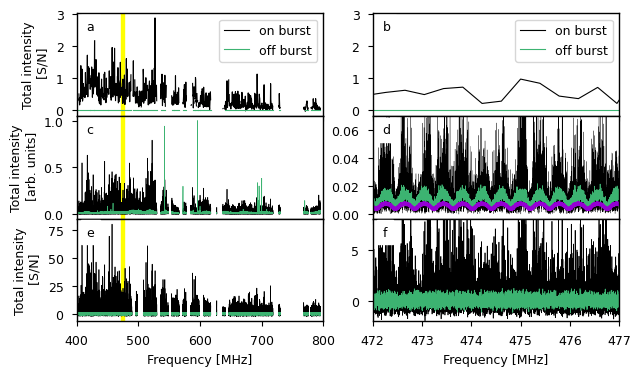

In [60]:
rows = 3
cols = 2
fig = plt.figure(figsize=(7,4))
gs = gridspec.GridSpec(ncols=cols, nrows=rows, width_ratios=[1,1], height_ratios=[1,1,1], wspace=0.2, hspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(freq,spec,color='k',lw=0.8,label='on burst')
ax1.plot(freq,offspec,color='mediumseagreen',alpha=1,lw=0.8, label='off burst')
ax1.set_xlim(400,800)
ax1.legend()
ax1.set_ylabel('Total intensity\n [S/N]')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.axvspan(472,477,color='yellow')
t=ax1.text(.04, .93, 'a', ha='left', va='top', transform=ax1.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
ax2.plot(data_dedisp_derippled_masked_upchan_512[1],spec_upchan/np.max(spec_fake_upchan),color='k',lw=0.5,label='on burst')
ax2.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan/np.max(spec_fake_upchan),color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax2.set_ylabel('Total intensity\n [arb. units]')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.axvspan(472,477,color='yellow')
t=ax2.text(.04, .93, 'c', ha='left', va='top', transform=ax2.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax3 = fig.add_subplot(gs[2,0],sharex=ax2)
ax3.plot(data_dedisp_derippled_masked_upchan_512[1],spec_upchan_corr,color='k',lw=0.5,label='on burst')
ax3.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan_corr,color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax3.set_ylabel('Total intensity\n [S/N]')
ax3.axvspan(472,477,color='yellow')

ax3.set_xlabel('Frequency [MHz]')

t=ax3.text(.04, .93, 'e', ha='left', va='top', transform=ax3.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax4 = fig.add_subplot(gs[0,1])
ax4.plot(freq,spec,color='k',lw=0.8,label='on burst')
ax4.plot(freq,offspec,color='mediumseagreen',alpha=1,lw=0.8, label='off burst')
ax4.set_xlim(472,477)
ax4.legend()
plt.setp(ax4.get_xticklabels(), visible=False)
t=ax4.text(.04, .93, 'b', ha='left', va='top', transform=ax4.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax5 = fig.add_subplot(gs[1,1],sharex=ax4)
ax5.plot(data_dedisp_derippled_masked_upchan_512[1],spec_upchan/np.max(spec_fake_upchan),color='k',lw=0.2,label='on burst')
ax5.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan/np.max(spec_fake_upchan),color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax5.plot(data_dedisp_derippled_masked_upchan_512[1],model_512/np.max(spec_fake_upchan),color='darkviolet',alpha=1,lw=3, label='scallop model')
ax5.set_ylim(-0.003,0.07)
plt.setp(ax5.get_xticklabels(), visible=False)
t=ax5.text(.04, .93, 'd', ha='left', va='top', transform=ax5.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax6 = fig.add_subplot(gs[2,1],sharex=ax5)
ax6.plot(data_dedisp_derippled_masked_upchan_512[1],spec_upchan_corr,color='k',lw=0.5,label='on burst')
ax6.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan_corr,color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax6.set_ylim(-2,8.1)


ax6.set_xlabel('Frequency [MHz]')
t=ax6.text(.04, .93, 'f', ha='left', va='top', transform=ax6.transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

fig.tight_layout(pad=1)
plt.savefig('./spectrum_pa_swing.rev.jpg',format='jpg',dpi=300)


plt.show()

# Autocorrelation function across the entire band

In [55]:
#let's do some additional flagging determined by making ACFs of the off burst data

spec_fake_upchan_corr[newinds]=0
spec_upchan_corr[newinds]=0

spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-501.76))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-501.76))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-504.88))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-504.88))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-492.38))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-492.38))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-643.75))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-643.75))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-602.35))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-602.35))+4096]=0

spec_fake_upchan_corr=np.ma.masked_where(spec_fake_upchan_corr==0,spec_fake_upchan_corr)


spec_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-501.76))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-501.76))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-504.88))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-504.88))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-492.38))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-492.38))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-643.75))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-643.75))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-602.35))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-602.35))+4096]=0

spec_upchan_corr=np.ma.masked_where(spec_upchan_corr==0,spec_upchan_corr)


spec_fake_upchan_corr2[newinds]=0


spec_fake_upchan_corr2[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-501.76))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-501.76))+4096]=0
spec_fake_upchan_corr2[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-504.88))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-504.88))+4096]=0
spec_fake_upchan_corr2[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-492.38))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-492.38))+4096]=0
spec_fake_upchan_corr2[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-643.75))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-643.75))+4096]=0
spec_fake_upchan_corr2[np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-602.35))-4096:np.argmin(np.abs(noise_dedisp_derippled_masked_upchan_512[1]-602.35))+4096]=0

spec_fake_upchan_corr2=np.ma.masked_where(spec_fake_upchan_corr2==0,spec_fake_upchan_corr2)




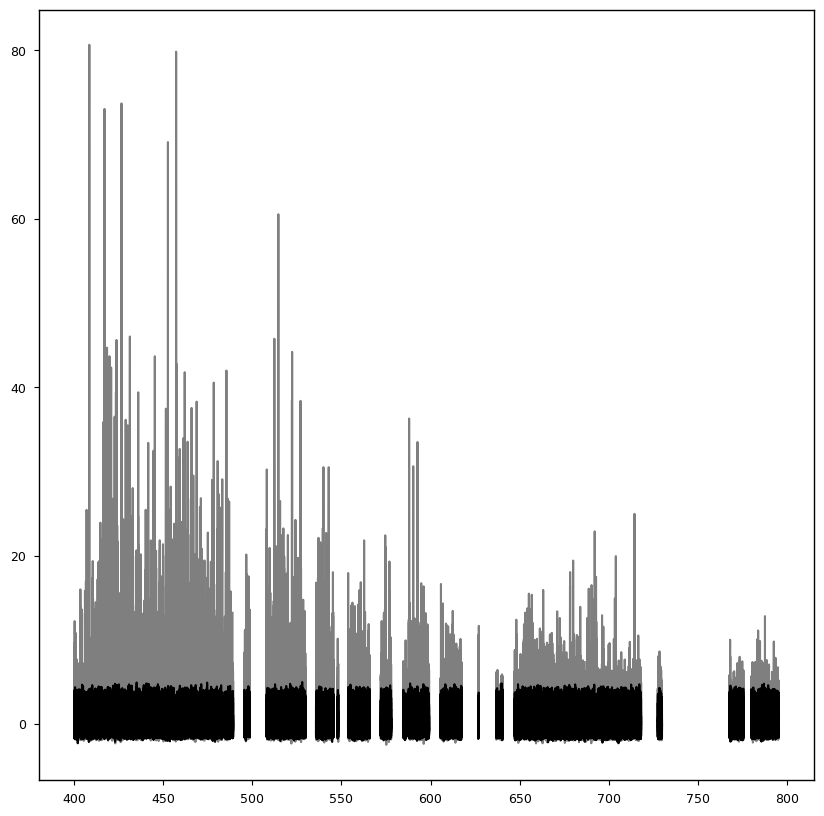

In [56]:
plt.plot(data_dedisp_derippled_masked_upchan_512[1],spec_upchan_corr,color='k',alpha=0.5)
plt.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan_corr,color='k')
plt.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan_corr2,color='k')
#plt.xlim(602.2,602.5)

In [57]:
#need to compute K from Method 2 in Macquart et al. 2019
# Kv^-1.5

def macquart_method_2(x,k,alpha):
    return k*x**-alpha

popt,pcov=curve_fit(macquart_method_2,data_dedisp_derippled_masked_upchan_512[1],spec_upchan_corr)

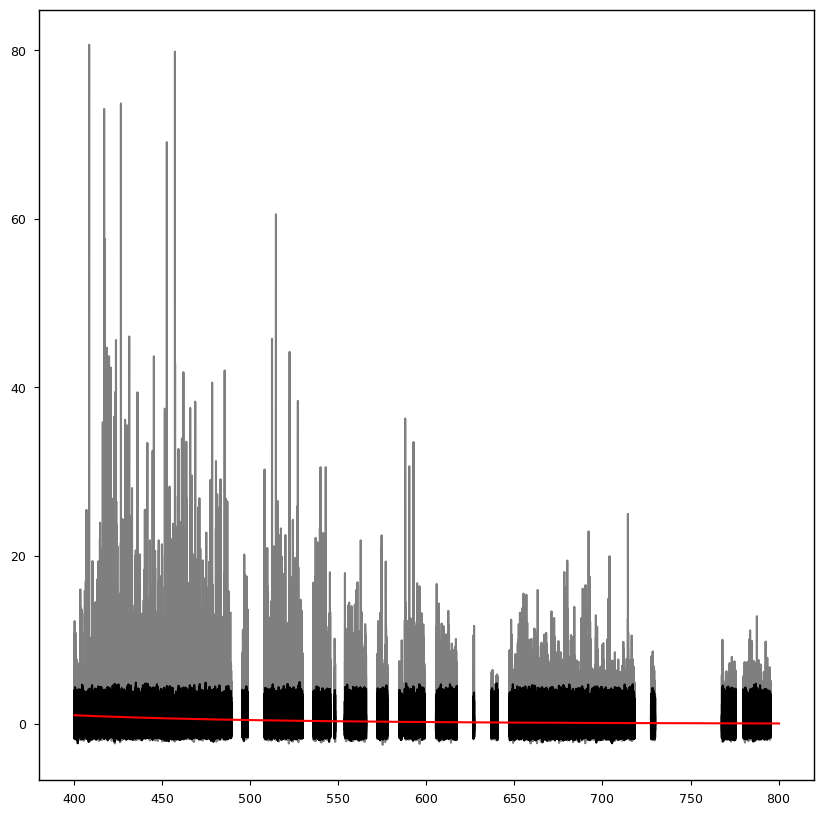

In [58]:
plt.plot(data_dedisp_derippled_masked_upchan_512[1],spec_upchan_corr,color='k',alpha=0.5)
plt.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan_corr,color='k')
plt.plot(data_dedisp_derippled_masked_upchan_512[1],spec_fake_upchan_corr2,color='k')
plt.plot(data_dedisp_derippled_masked_upchan_512[1],macquart_method_2(data_dedisp_derippled_masked_upchan_512[1],*popt),color='r')

In [59]:
print(popt)
print(pcov)

k_fixed=popt[0]

[1.03055693e+09 3.45091162e+00]
[[4.81140918e+16 7.57061741e+06]
 [7.57061741e+06 1.19185765e-03]]


[2024-08-22 14:27:09,920] INFO Authorization Method: Tokens
[2024-08-22 14:27:10,589] INFO Authorization Token : Expired
[2024-08-22 14:27:10,591] INFO Reauthorize Method: Tokens
[2024-08-22 14:27:11,743] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2024-08-22 14:27:11,744] INFO Reauthorize Result: Passed


Frequency resolution is 0.00076 MHz


100%|██████████| 26214/26214 [09:19<00:00, 46.87it/s]


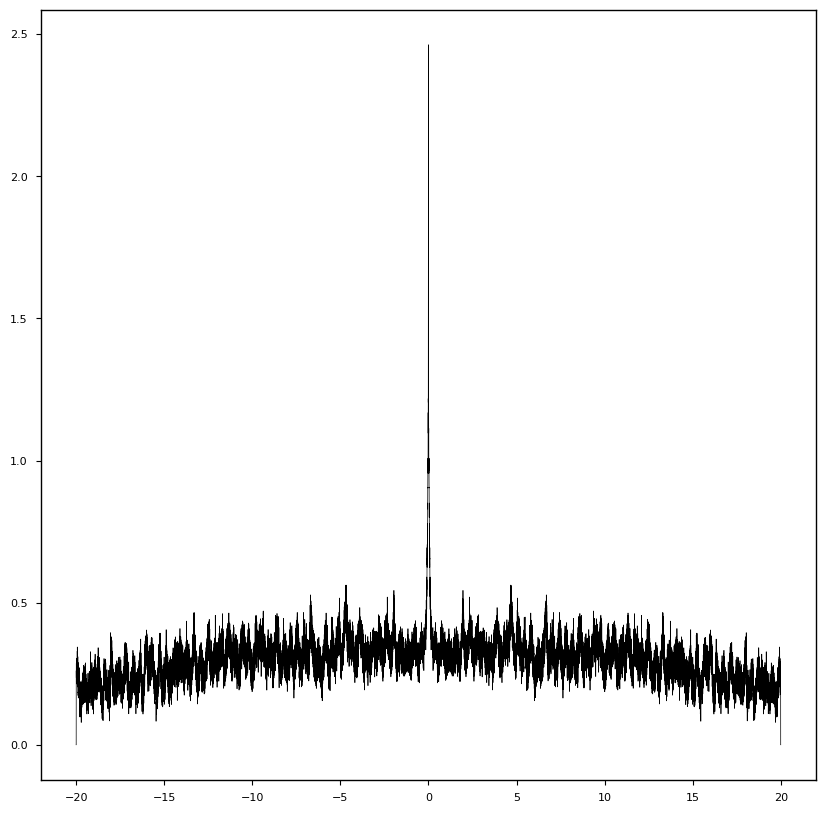

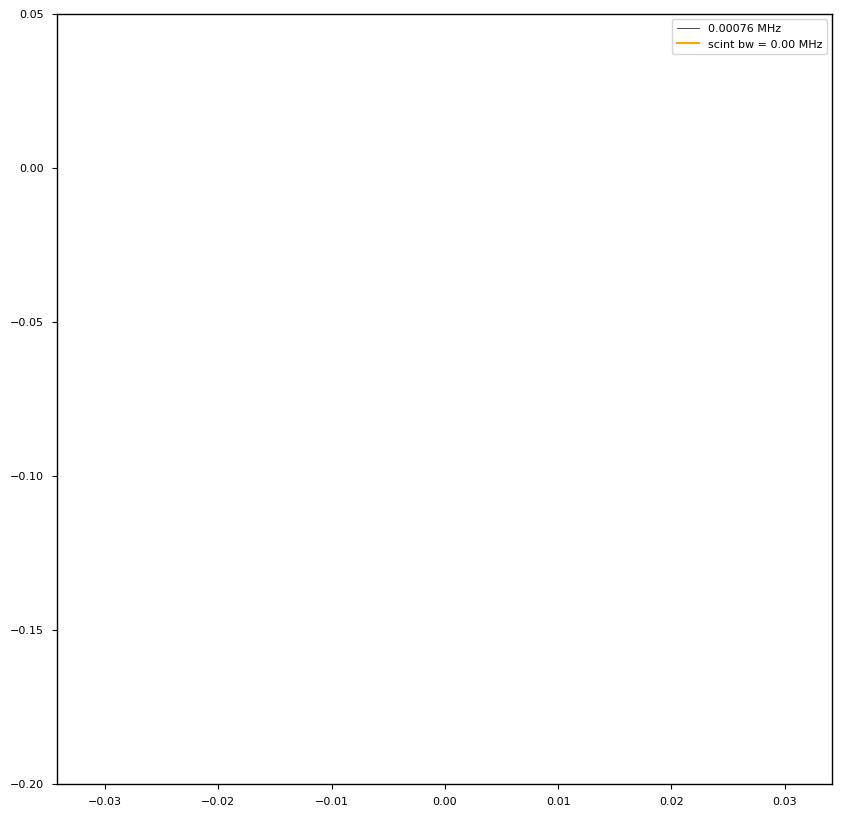

In [49]:
acf_res = acf_scint_plot(spec_upchan_corr,data_dedisp_derippled_masked_upchan_512[2],data_dedisp_derippled_masked_upchan_512[1],[0,0],lagrange_for_fit=0.01,diagnostic_plots=True,maxlag=20,offspec_mean=(np.nanmean(spec_fake_upchan_corr2)))
#offacf_res = acf_scint_plot(spec_fake_upchan_corr2,noise_dedisp_derippled_masked_upchan_512[2],noise_dedisp_derippled_masked_upchan_512[1],[0,0],lagrange_for_fit=0.01,diagnostic_plots=True,maxlag=15)



/tmp/ipykernel_42/1678215659.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 52246
    # variables        = 6
    chi-square         = 462.242318
    reduced chi-square = 0.00884844
    Akaike info crit   = -246987.724
    Bayesian info crit = -246934.541
[[Variables]]
    gamma1:  0.00303077 +/- 4.3101e-05 (1.42%) (init = 0.02)
    m1:      1.28879271 +/- 0.00447963 (0.35%) (init = 1)
    gamma2:  0.05361563 +/- 4.3154e-04 (0.80%) (init = 0.2)
    m2:      0.88966405 +/- 0.00281563 (0.32%) (init = 1)
    gamma3:  27.2739989 +/- 0.10627100 (0.39%) (init = 2)
    m3:      0.58221999 +/- 2.8135e-04 (0.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma2, m2)     = -0.7924
    C(gamma1, m1)     = -0.6990
    C(gamma3, m3)     = -0.6550
    C(gamma1, m2)     = -0.6544
    C(gamma1, gamma2) = +0.4824
    C(gamma2, m3)     = -0.2050
    C(gamma2, gamma3) = +0.1334
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # functio

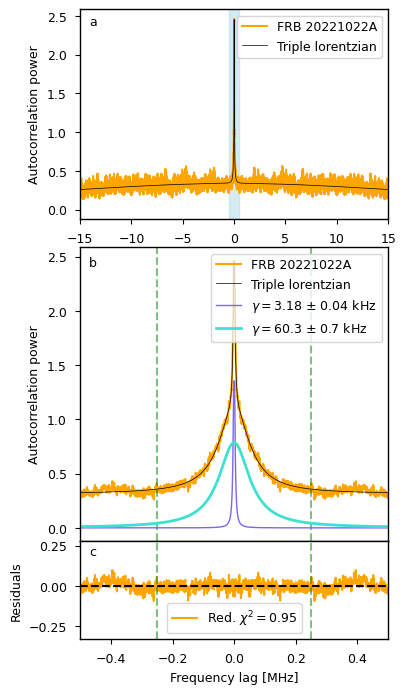

In [69]:
fig = plt.figure(figsize=(3.5,7))

gs = gridspec.GridSpec(ncols=1, nrows=1, top=0.94, bottom=0.64, left=0.09,right=0.97, width_ratios=[1], height_ratios=[1], wspace=0, hspace=0)
gs1 = gridspec.GridSpec(ncols=1, nrows=2, top=0.6, bottom=0.04, left=0.09,right=0.97,width_ratios=[1], height_ratios=[3,1], wspace=0, hspace=0)

cmap = matplotlib.cm.get_cmap('plasma')
lagrange_for_fit=19.95#14.95
f_res=0.39101/(fftsize//downfreq)

acf=acf_res[0]
lag=acf_res[1]
acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]

#compute the ACF errors
acf_half = acf[len(acf)//2:]
var_f = np.ones(len(acf_half)) / (len(acf_half))
var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
f_errors = np.sqrt(var_f)
    
f_errors_full = np.concatenate((f_errors[::-1],f_errors))
acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
        

ax1 = fig.add_subplot(gs[0,0])
ax1.set_ylabel('Autocorrelation power')
ax1.axvspan(-0.5,0.5,color='lightblue',alpha=0.5)
ax1.plot(acf_res[1],acf_res[0],color='orange',label='FRB 20221022A')


params = Parameters()
params.add('gamma1', value = 0.02, min= 0.00001, max = 100)
params.add('m1', value = 1, min = -100, max = 100)
params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
params.add('m2', value = 1, min = -100, max = 100)
params.add('gamma3', value = 2, min= 0.00001, max = 100)
params.add('m3', value = 1, min = -100, max = 100)
        
    
fit = Minimizer(triplelorentz_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
result_fullacf = fit.minimize()
print(report_fit(result_fullacf))
        
ax1.plot(lag,triplelorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3']),color='k',linewidth=0.5,label='Triple lorentzian')
ax1.set_xlim(-15,15)
ax1.legend()
ax1.text(.03, .97, 'a', ha='left', va='top', transform=ax1.transAxes)

lagrange_for_fit=0.5
f_res=0.39101/(fftsize//downfreq)

acf=acf_res[0]
lag=acf_res[1]
acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]

#compute the ACF errors
acf_half = acf[len(acf)//2:]
var_f = np.ones(len(acf_half)) / (len(acf_half))
var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
f_errors = np.sqrt(var_f)
    
f_errors_full = np.concatenate((f_errors[::-1],f_errors))
acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]


params = Parameters()
params.add('gamma1', value = 0.02, min= 0.00001, max = 100)
params.add('m1', value = 1, min = -100, max = 100)
params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
params.add('m2', value = 1, min = -100, max = 100)
params.add('gamma3', value = 20, min= 0.00001, max = 100)
params.add('m3', value = 1, min = -100, max = 100)
        
    
fit = Minimizer(triplelorentz_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
result_fullacf = fit.minimize()
print(report_fit(result_fullacf))




ax2 = fig.add_subplot(gs1[0,0])
ax2.set_ylabel('Autocorrelation power')
ax2.plot(acf_res[1],acf_res[0],color='orange',label='FRB 20221022A')
ax2.plot(lag,triplelorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3']),color='k',linewidth=0.5,label='Triple lorentzian')
ax2.axvline(-0.25,color='green',linestyle='--',alpha=0.5)
ax2.axvline(0.25,color='green',linestyle='--',alpha=0.5)
ax2.set_xlim(-0.5,0.5)
ax2.plot(lag,lorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1']),color='mediumslateblue',lw=1,label=r'$\gamma = $%.2f $\pm$ %.2f kHz'%(result_fullacf.params['gamma1']*1000, (result_fullacf.params['gamma1'].stderr)*1000))
ax2.plot(lag,lorentz(lag,result_fullacf.params['gamma2'],result_fullacf.params['m2']),color='turquoise',lw=2,label=r'$\gamma = $%.1f $\pm$ %.1f kHz'%(result_fullacf.params['gamma2']*1000, (result_fullacf.params['gamma2'].stderr)*1000))
ax2.legend(loc='upper right')
ax2.text(.03, .97, 'b', ha='left', va='top', transform=ax2.transAxes)

lagrange_for_stat = 0.25
acf_stat = acf[int(len(acf)/2.)-int(lagrange_for_stat/f_res):int(len(acf)/2.)+int(lagrange_for_stat/f_res)]
lag_stat=lag[int(len(acf)/2.)-int(lagrange_for_stat/f_res):int(len(acf)/2.)+int(lagrange_for_stat/f_res)]
dof = len(acf_stat)-4
E = triplelorentz(lag_stat,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3'])
instrip_m = result_fullacf.params['m3']
instrip_gamma = result_fullacf.params['gamma3']
acf_highlag = acf[int(len(acf)/2.)+int(0.4/f_res):int(len(acf)/2.)+int(0.5/f_res)] - instrip_m**2 / (1+(lag[int(len(acf)/2.)+int(0.4/f_res):int(len(acf)/2.)+int(0.5/f_res)]/instrip_gamma)**2)
chisq_k = np.sum((acf_stat-E)**2 * 1/np.var(acf_highlag))
redchisq=chisq_k/dof
print("chisq",chisq_k)
print("reduced chisq",redchisq)


ax3 = fig.add_subplot(gs1[1,0],sharex=ax2)
ax3.set_ylabel('Residuals')
ax3.set_xlabel('Frequency lag [MHz]')
ax3.plot(lag,acf_res[0]-triplelorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3']),color='orange',label=r'Red. $\chi^2 = $%.2f'%redchisq)
ax3.axhline(0,color='k',linestyle='--')
ax3.legend(loc='lower center')
ax3.axvline(-0.25,color='green',linestyle='--',alpha=0.5)
ax3.axvline(0.25,color='green',linestyle='--',alpha=0.5)
ax3.set_xlim(-0.5,0.5)
ax3.text(.03, .96, 'c', ha='left', va='top', transform=ax3.transAxes)
#fig.tight_layout(pad=3)

plt.savefig('./entire_band_ACF_FRB20221022A.rev.pdf',format='pdf',dpi=300,bbox_inches="tight")





## ACF per subband

[2024-08-21 15:20:28,185] INFO Authorization Method: Tokens
[2024-08-21 15:20:28,621] INFO Authorization Token : Expired
[2024-08-21 15:20:28,622] INFO Reauthorize Method: Tokens
[2024-08-21 15:20:29,246] WARNING It is required that you pass in a value for the "algorithms" argument when calling decode().
[2024-08-21 15:20:29,248] INFO Reauthorize Result: Passed


beg,end 0 181995
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:18<00:00, 285.33it/s]


Could not fit a Lorentzian
beg,end 181995 297685
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:11<00:00, 464.72it/s]


Could not fit a Lorentzian
beg,end 297685 363285
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:06<00:00, 795.90it/s]


Could not fit a Lorentzian
beg,end 363285 417014
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:05<00:00, 946.57it/s]


Could not fit a Lorentzian
beg,end 417014 445766
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:03<00:00, 1678.21it/s]


Could not fit a Lorentzian
beg,end 445766 471781
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:02<00:00, 1816.56it/s]


Could not fit a Lorentzian
beg,end 471781 495622
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:02<00:00, 1997.64it/s]


Could not fit a Lorentzian
beg,end 495622 524207
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:03<00:00, 1703.72it/s]


Could not fit a Lorentzian


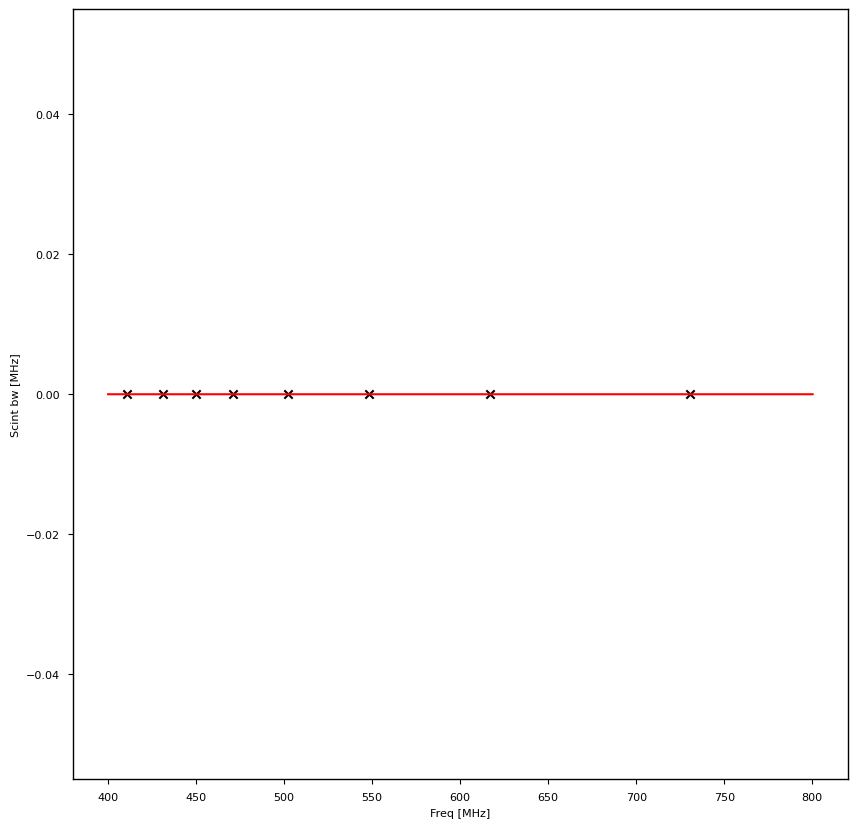

In [27]:
acfs,fcents,lags, subsn, submask,spec_lens=acf_per_subband(spec_upchan_corr,data_dedisp_derippled_masked_upchan_512[1],data_dedisp_derippled_masked_upchan_512[2],num_subbands=8,plot_fit=True,maxlag=4,offspec=spec_fake_upchan_corr2,snsubband=True)


/tmp/ipykernel_42/1074835912.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 250
    # data points      = 784
    # variables        = 5
    chi-square         = 51.0349669
    reduced chi-square = 0.06551344
    Akaike info crit   = -2131.80803
    Bayesian info crit = -2108.48599
[[Variables]]
    gamma1:  2.0337e-04 +/- 8.6219e-04 (423.96%) (init = 0.002)
    m1:      7.03916814 +/- 29.2662766 (415.76%) (init = 1)
    gamma2:  0.03336389 +/- 0.00134668 (4.04%) (init = 0.2)
    m2:      0.82148427 +/- 0.01029591 (1.25%) (init = 1)
    c:       0.15455437 +/- 0.00464010 (3.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1)     = -1.0000
    C(gamma2, m2)     = -0.6470
    C(gamma1, m2)     = -0.6128
    C(m1, m2)         = +0.6110
    C(gamma2, c)      = -0.5673
    C(gamma1, gamma2) = +0.4479
    C(m1, gamma2)     = -0.4464
    C(gamma1, c)      = -0.1474
    C(m1, c)          = +0.1468
None
[[Fit Statistics]]
    # fitting method   = leastsq
   

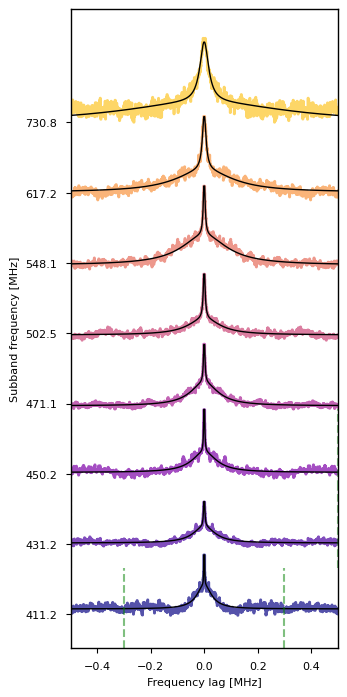

In [28]:
#doublelorentz
fig = plt.figure(figsize=(3.5,7))

cmap = matplotlib.cm.get_cmap('plasma')
lagrange_for_fits=[0.3,0.5,0.5,0.6,0.6,0.7,0.7,3]
#lagrange_for_fits=[0.3,0.5,0.5,0.6,0.6,1,1,1,1,1]
f_res=0.39101/(fftsize//downfreq)
sub_scint=[]
sub_scint_uncert=[]
sub_scint2=[]
sub_scint_uncert2=[]
f_cents=[]

#plt.ytick_labels(fcent)
plt.xlabel('Frequency lag [MHz]')
plt.ylabel('Subband frequency [MHz]')
acfs_offset=[]
mods1=[]
mods1_uncert=[]
mods2=[]
mods2_uncert=[]
for i in range(len(fcents)):
    lagrange_for_fit=lagrange_for_fits[i]
    rgba = cmap(i/len(fcents))
    acf=acfs[len(fcents)-i-1]
    lag=lags[len(fcents)-i-1]
    acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    plt.plot(lags[len(fcents)-i-1],acfs[len(fcents)-i-1]+(2.0*i),drawstyle='steps-mid',color=rgba,linewidth=2,alpha=0.7,label='%.2f MHz'%fcents[len(fcents)-i-1])
    
    #compute the ACF errors
    acf_half = acf[len(acf)//2:]
    var_f = np.ones(len(acf_half)) / (len(acf_half))
    var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
    f_errors = np.sqrt(var_f)
    
    f_errors_full = np.concatenate((f_errors[::-1],f_errors))
    acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
    
    fit=True
    try:
        params = Parameters()
        params.add('gamma1', value = 0.002, min= 0.00001, max = 100)
        params.add('m1', value = 1, min = -100, max = 100)
        params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
        params.add('m2', value = 1, min = -100, max = 100)
        params.add('c', value = 0, min = -100, max = 100)
        
    
        fit_min = Minimizer(doublelorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
        result_subacf = fit_min.minimize()
        print(report_fit(result_subacf))
    except:
        print('could not fit')
        fit=False
    
    
        
    if fit==True:
        plt.plot(lags[len(fcents)-i-1],doublelorentz_w_c(lags[len(fcents)-i-1],result_subacf.params['gamma1'],result_subacf.params['m1'],result_subacf.params['gamma2'],result_subacf.params['m2'],result_subacf.params['c'])+(2.0*i),color='k',linewidth=1)
        
        scints=np.array([np.abs(result_subacf.params['gamma1']),np.abs(result_subacf.params['gamma2'])])
        modinds=np.array([np.abs(result_subacf.params['m1']),np.abs(result_subacf.params['m2'])])
        inds=np.argsort(scints)
        scints=scints[inds]
        modinds=modinds[inds]
        sub_scint.append(scints[0])
        sub_scint2.append(scints[1])
        mods1.append(modinds[0])
        mods2.append(modinds[1])
        errs = np.array([np.abs(result_subacf.params['gamma1'].stderr),np.abs(result_subacf.params['gamma2'].stderr)])
        errs=errs[inds]
        sub_scint_uncert.append(errs[0])
        sub_scint_uncert2.append(errs[1])
        moderrs = np.array([np.abs(result_subacf.params['m1'].stderr),np.abs(result_subacf.params['m2'].stderr)])
        moderrs=moderrs[inds]
        mods1_uncert.append(moderrs[0])
        mods2_uncert.append(moderrs[1])
    else:
        sub_scint.append(0)
        sub_scint_uncert.append(0)
        sub_scint2.append(0)
        sub_scint_uncert2.append(0) 
        
    acfs_offset.append(acfs[len(fcents)-i-1]+(2.0*i))
        
    f_cents.append(fcents[len(fcents)-i-1])

    plt.axvline(lagrange_for_fit,ymin=0+(0.125*i),ymax=0+(0.125*i)+0.125,color='green',linestyle='--',alpha=0.5)
    plt.axvline(-1*lagrange_for_fit,ymin=0+(0.125*i),ymax=0+(0.125*i)+0.125,color='green',linestyle='--', alpha=0.5)
    

plt.yticks([x[0] for x in acfs_offset],['%.1f'%x for x in np.flip(fcents)])

plt.xlim(-0.5,0.5)
fig.tight_layout(pad=1)


In [29]:
# #additional uncertainty from the low number of scintles (1/sqrt(N) where N is the approximate number of scintles)
# add_un2 = 1./np.sqrt((50 - (np.flip(np.array(submask))*f_res)) / sub_scint2)

# add_un = 1./np.sqrt((50 - (np.flip(np.array(submask))*f_res)) / sub_scint)

good_chans=np.array(spec_lens)-np.array(submask)
N2 = 1 + 0.2*((np.flip(good_chans)*f_res) / sub_scint2)
#N2 = 1 + 0.2*((np.flip(np.array(submask))*f_res) / sub_scint2)
add_un2 = sub_scint2/(2*np.sqrt(N2))

good_chans=np.array(spec_lens)-np.array(submask)
N = 1 + 0.2*((np.flip(good_chans)*f_res) / sub_scint)
#N = 1 + 0.2*((np.flip(np.array(submask))*f_res) / sub_scint)
add_un = sub_scint/(2*np.sqrt(N))


# first let's fit to the scintillation bandwidths


In [30]:
def scint_freq_relation(v,c,n):
    return c*(v**n)

def scint_freq_relation_min(params,x,y,err):
    c = params['c'].value
    n = params['n'].value
        
    modulo=c*(x**n)
    return (modulo-y)/err
    


In [31]:
params = Parameters()
params.add('n', value = 4, min = 0, max = 10)
params.add('c', value = 1)

fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents,sub_scint,np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2)))
result_scint1 = fit_min.minimize()
print(report_fit(result_scint1))

fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents,sub_scint2,np.sqrt(np.array(sub_scint_uncert2)**2 + add_un2**2)))
result_scint2 = fit_min.minimize()
print(report_fit(result_scint2))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 8
    # variables        = 2
    chi-square         = 136.779187
    reduced chi-square = 22.7965312
    Akaike info crit   = 26.7114105
    Bayesian info crit = 26.8702936
[[Variables]]
    n:  4.47782985 +/- 0.41470397 (9.26%) (init = 4)
    c:  2.6897e-15 +/- 7.0895e-15 (263.57%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, c) = -0.9997
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 8
    # variables        = 2
    chi-square         = 28.4752766
    reduced chi-square = 4.74587943
    Akaike info crit   = 14.1567574
    Bayesian info crit = 14.3156405
[[Variables]]
    n:  3.56907342 +/- 0.31687116 (8.88%) (init = 4)
    c:  1.7091e-11 +/- 3.3659e-11 (196.94%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, c) = -0.9997
None


# now let's fit to the modulation indices

In [32]:
def two_screen_resolved(freq,d2,d12):#,distance_ext_lens, distance_gal_lens):
    #distance_ext_lens /= 1e6 
    scint_bws_1 = (freq/600)**3.1 * 132e3
    scint_bws_2 = (freq/600)**4.0 * 7e3
    #d12 = 65.189e3 - distance_ext_lens - distance_gal_lens#kpc
    
    #bracket = (freq*1e6/d12)**2 * (2*distance_ext_lens*distance_gal_lens)/ (scint_bws_1*scint_bws_2)
    bracket = (freq*1e6/d12)**2 * (2*d2)/ (scint_bws_1*scint_bws_2)
    second_sqrt = 1+(4*bracket)
    return 1/np.sqrt(second_sqrt)


def two_screen_resolved_min(params,freq,y,err):
    #distance_ext_lens = params['distance_ext_lens'].value
    #distance_gal_lens = params['distance_gal_lens'].value
    d2=params['d2'].value
    d12=params['d12'].value
    scint_bws_1 = (freq/600)**3.1 * 132e3
    scint_bws_2 = (freq/600)**4.0 * 7e3
    #d12 = 65.189e3 - distance_ext_lens - distance_gal_lens #kpc
    
    #bracket = (freq*1e6/d12)**2 * (2*distance_ext_lens*distance_gal_lens)/ (scint_bws_1*scint_bws_2)
    bracket = (freq*1e6/d12)**2 * (2*d2)/ (scint_bws_1*scint_bws_2)
    second_sqrt = 1+(4*bracket)
    modulo =  1/np.sqrt(second_sqrt)
    
    return (modulo - y)/err

def emission_resolved(freq,emission_size,distance_ext_lens):
    distance_ext_lens *= 3.086e19 #provide in kpc --> change to m
    emission_size *=1e3 #provide in km --> change to m
    scint_bws = (freq/600)**3.1 * 132e3
    chi_s2 = 1/(freq*1e6) * np.sqrt((scipy.constants.c * distance_ext_lens * scint_bws)/(2*np.pi))
    second_sqrt = 1+(4*(emission_size/chi_s2)**2)
    return 1/np.sqrt(second_sqrt)


def emission_resolved_min(params,freq,y,err):
    distance_ext_lens = params['distance_ext_lens'].value * 3.086e19
    emission_size = params['emission_size'].value * 1e3
    scint_bws = (freq/600)**3.1 * 132e3
    chi_s2 = 1/(freq*1e6) * np.sqrt((scipy.constants.c * distance_ext_lens * scint_bws)/(2*np.pi))
    second_sqrt = 1+(4*(emission_size/chi_s2)**2)
    modulo =  1/np.sqrt(second_sqrt)
    return (modulo - y)/err

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 7
    # variables        = 2
    chi-square         = 554.998547
    reduced chi-square = 110.999709
    Akaike info crit   = 34.6113874
    Bayesian info crit = 34.5032077
[[Variables]]
    emission_size:      57527.7568 +/- 22634360.4 (39345.11%) (init = 1000)
    distance_ext_lens:  49.4486127 +/- 38951.3637 (78771.40%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(emission_size, distance_ext_lens) = +1.0000
None


Text(0, 0.5, 'Modulation index')

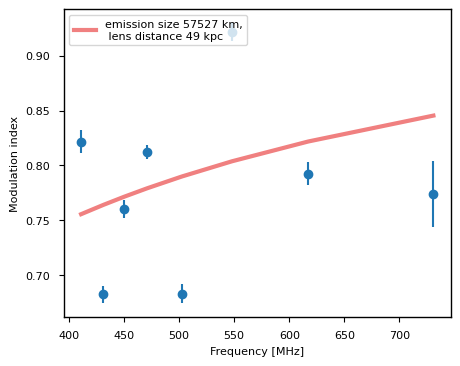

In [33]:
params = Parameters()
params.add('emission_size', value = 1e3, min= 1, max = 1e10)
params.add('distance_ext_lens', value = 1, min = 0.001, max = 500)

fit = Minimizer(emission_resolved_min, params, fcn_args=(np.array(f_cents[0:-1]),mods2[0:-1],np.sqrt(np.array(mods2_uncert[0:-1])**2 + add_un2[0:-1]**2)))
result_resem = fit.minimize()
print(report_fit(result_resem))

fig = plt.figure(figsize=[5,4])
plt.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o')
plt.plot(f_cents,emission_resolved(np.array(f_cents),result_resem.params['emission_size'],result_resem.params['distance_ext_lens']),color='lightcoral',lw=3,label='emission size %d km,\n lens distance %d kpc'%(result_resem.params['emission_size'],result_resem.params['distance_ext_lens']))
plt.legend(loc='upper left')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Modulation index')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 7
    # variables        = 2
    chi-square         = 763.393265
    reduced chi-square = 152.678653
    Akaike info crit   = 36.8430422
    Bayesian info crit = 36.7348625
[[Variables]]
    d2:   0.23392728 +/- 3.84253699 (1642.62%) (init = 10000)
    d12:  63792.9185 +/- 514186.352 (806.02%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(d2, d12) = +0.9999
None


Text(0, 0.5, 'Modulation index')

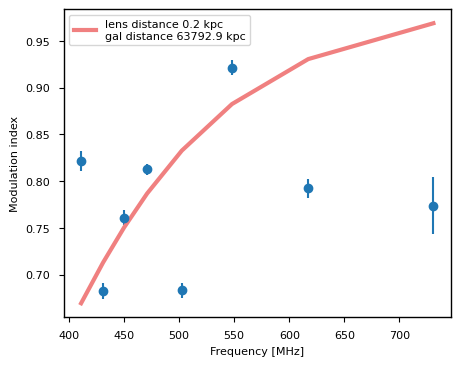

In [34]:
#temp
params = Parameters()
params.add('d2', value = 10000, min = 0.0000001, max = 50000000)
params.add('d12', value = 10e3, min = 0.1, max =65.189e3 )

fit = Minimizer(two_screen_resolved_min, params, fcn_args=(np.array(f_cents)[0:-1],mods2[0:-1],np.sqrt(np.array(mods2_uncert[0:-1])**2 + add_un2[0:-1]**2)))
result_ressc = fit.minimize()
print(report_fit(result_ressc))

fig = plt.figure(figsize=[5,4])
plt.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o')
plt.plot(f_cents,two_screen_resolved(np.array(f_cents),result_ressc.params['d2'],result_ressc.params['d12']),color='lightcoral',lw=3,label='lens distance %.1f kpc\ngal distance %.1f kpc'%(result_ressc.params['d2'],result_ressc.params['d12']))#label='d1*d2 = %d kpc^2'%(result.params['d1d2']))
plt.legend(loc='upper left')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Modulation index')

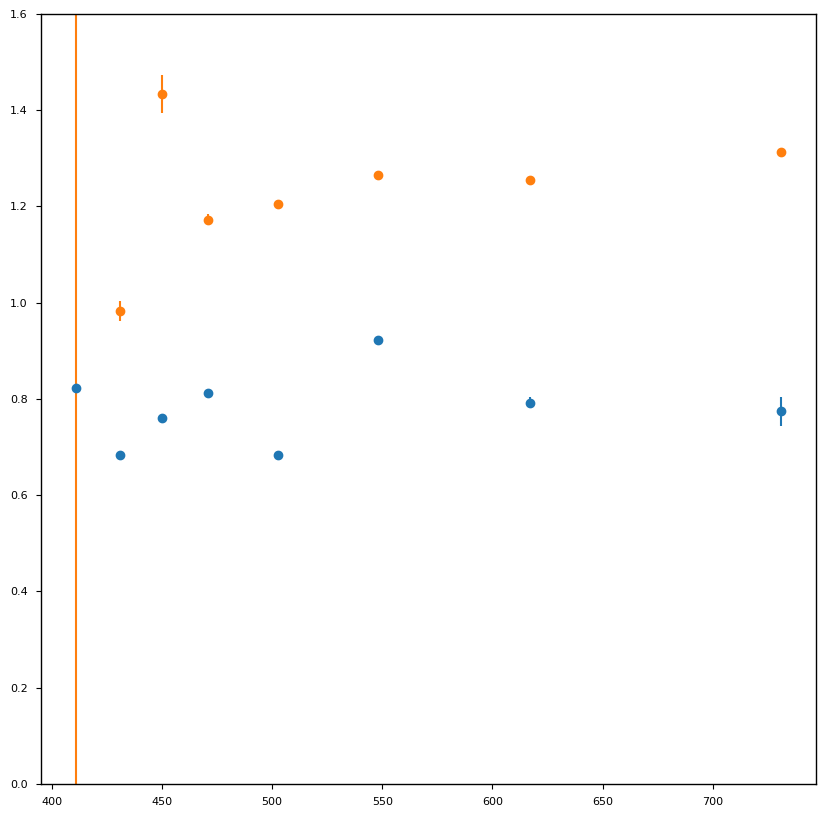

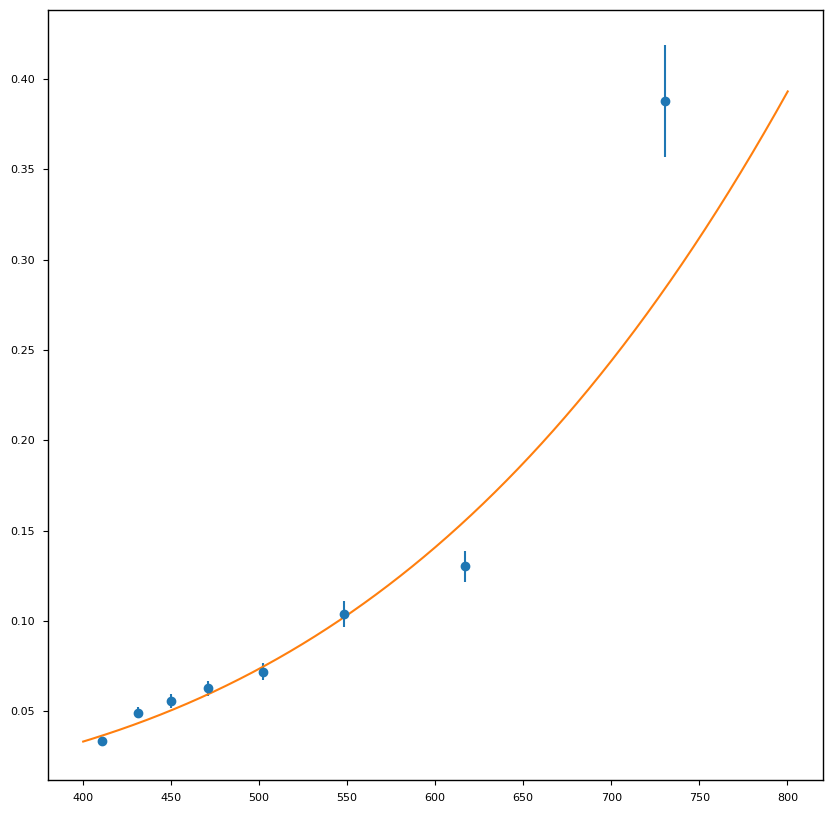

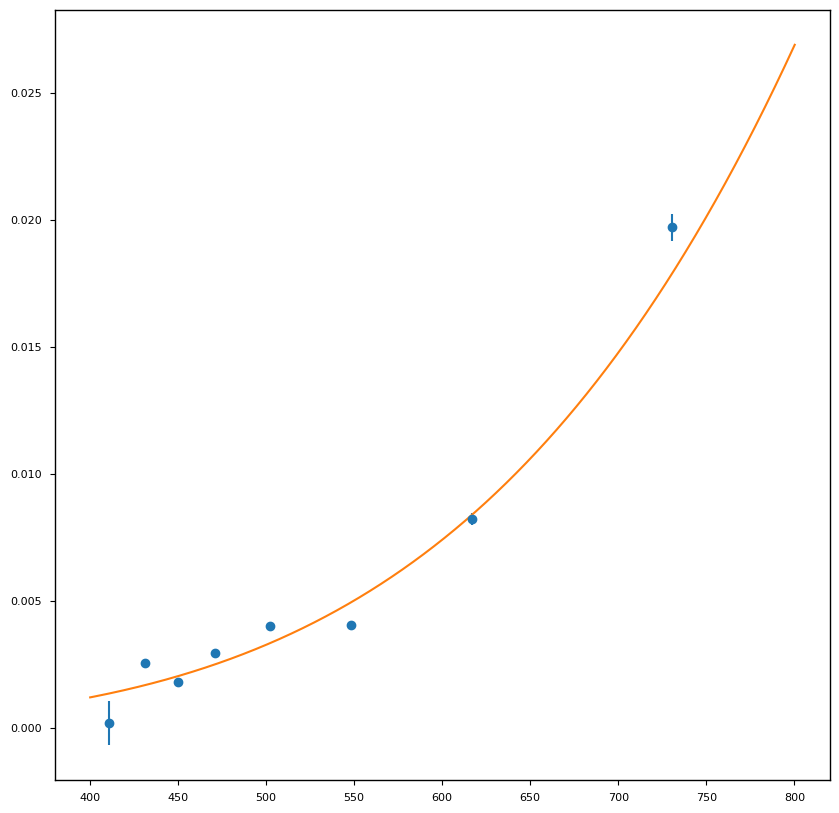

In [35]:
plt.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o')
plt.errorbar(f_cents,mods1,yerr=np.sqrt(np.array(mods1_uncert)**2 + add_un**2),linestyle='none',marker='o')
plt.ylim(0,1.6)
plt.show()

plt.errorbar(f_cents,sub_scint2,yerr=np.sqrt(np.array(sub_scint_uncert2)**2 + add_un2**2),linestyle='none',marker='o')
plt.plot(data_dedisp_derippled_masked_upchan_512[1],scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value))
plt.show()

plt.errorbar(f_cents,sub_scint,yerr=np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2),linestyle='none',marker='o')
plt.plot(data_dedisp_derippled_masked_upchan_512[1],scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value))
plt.show()

In [36]:
import math
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))


In [37]:
weighted_avg_and_std(np.array(mods2), np.sqrt(np.array(mods2_uncert)**2 + add_un2**2))

(0.7796272979917667, 0.06207626252328409)

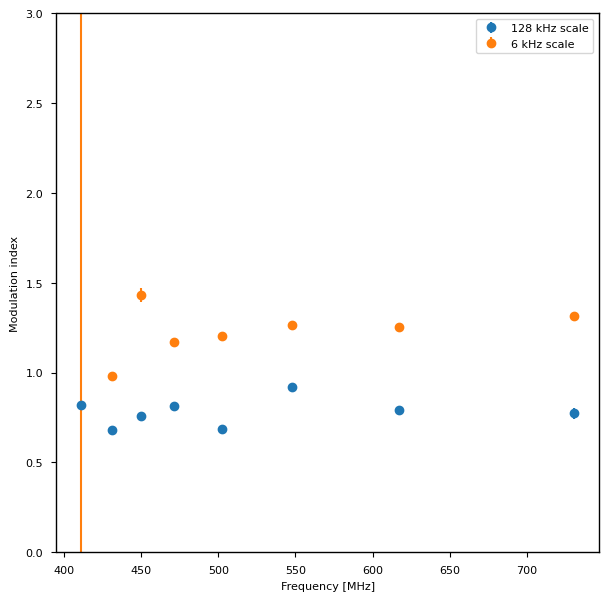

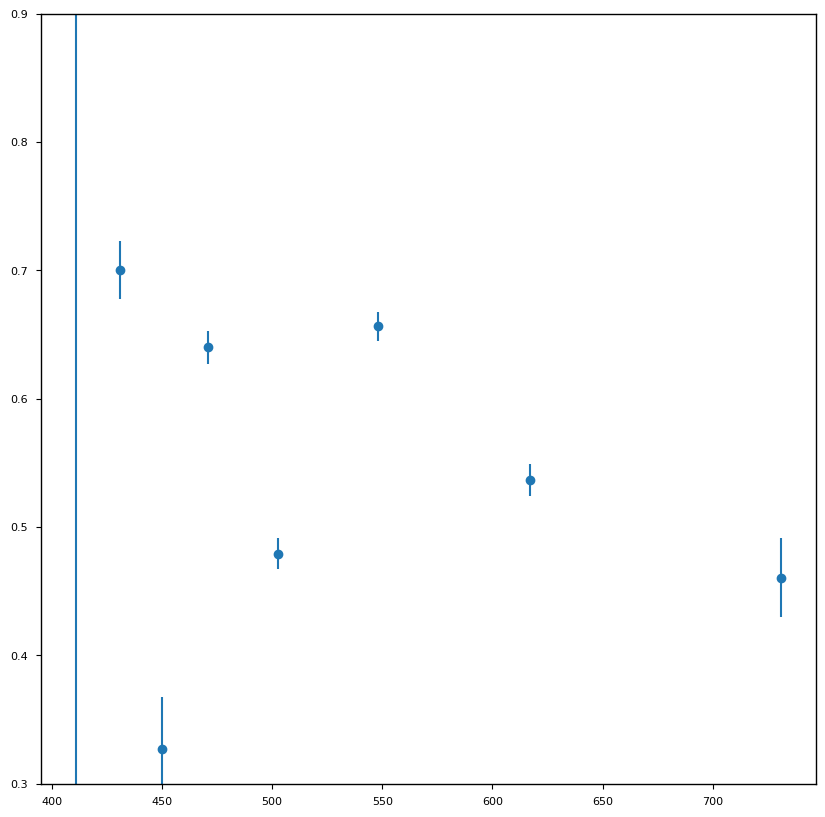

In [38]:
fig = plt.figure(figsize=[7,7])
plt.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o',label='128 kHz scale')
plt.errorbar(f_cents,mods1,yerr=np.sqrt(np.array(mods1_uncert)**2 + add_un**2),linestyle='none',marker='o',label='6 kHz scale')
plt.ylim(0,3)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Modulation index')
plt.legend(loc='upper right')
plt.show()

plt.errorbar(f_cents,np.array(mods2) - (np.array(mods1)-1), yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2 + np.array(mods1_uncert)**2 + add_un**2),linestyle='none',marker='o')
plt.ylim(0.3,0.9)
plt.show()

In [40]:
def lin(x,grad,c):
    return grad*x + c

def linmin(params, x, y, errs):
    grad = params['grad'].value
    c = params['c'].value

    modelo = grad*x + c
    return (modelo - y)/errs

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 296
    # data points      = 784
    # variables        = 5
    chi-square         = 51.0349668
    reduced chi-square = 0.06551344
    Akaike info crit   = -2131.80803
    Bayesian info crit = -2108.48599
[[Variables]]
    gamma1:  2.0155e-04 +/- 8.7570e-04 (434.49%) (init = 0.02)
    m1:      7.10147852 +/- 30.4795325 (429.20%) (init = 1)
    gamma2:  0.03336323 +/- 0.00134656 (4.04%) (init = 0.2)
    m2:      0.82149484 +/- 0.01029527 (1.25%) (init = 1)
    c:       0.15455457 +/- 0.00464001 (3.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1)     = -1.0000
    C(gamma2, m2)     = -0.6470
    C(gamma1, m2)     = -0.6128
    C(m1, m2)         = +0.6111
    C(gamma2, c)      = -0.5673
    C(gamma1, gamma2) = +0.4479
    C(m1, gamma2)     = -0.4464
    C(gamma1, c)      = -0.1474
    C(m1, c)          = +0.1468
None
[[Fit Statistics]]
    # fitting method   = leastsq
    

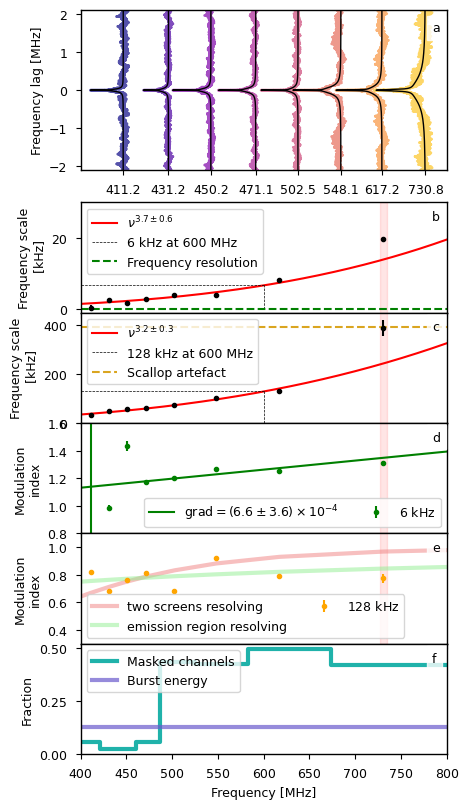

In [80]:
fig = plt.figure(figsize=(4.72441,8))

gs1 = gridspec.GridSpec(ncols=1, nrows=1, top=0.97, bottom=0.77, width_ratios=[1], height_ratios=[1], wspace=0, hspace=0)
gs = gridspec.GridSpec(ncols=1, nrows=5, top=0.73, bottom=0.04, width_ratios=[1], height_ratios=[1,1,1,1,1], wspace=0, hspace=0)

ax1 = fig.add_subplot(gs1[0,0]) 

#lagranges_for_fit=[0.3,0.5,0.5,0.6,0.6,3]
lagranges_for_fit=[0.3,0.5,0.5,0.6,0.6,0.7,0.7,3]
f_res=0.39101/(fftsize//downfreq)
sub_scint=[]
sub_scint_uncert=[]
sub_scint2=[]
sub_scint_uncert2=[]
f_cents=[]
acfs_offset=[]
mods1=[]
mods1_uncert=[]
mods2=[]
mods2_uncert=[]
for i in range(len(fcents)):
    lagrange_for_fit=lagranges_for_fit[i]
    rgba = cmap(i/len(fcents))
    acf=acfs[len(fcents)-i-1]
    lag=lags[len(fcents)-i-1]
    acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    ax1.plot(-1*acfs[len(fcents)-i-1]+(2.0*i),lags[len(fcents)-i-1],drawstyle='steps-mid',color=rgba,linewidth=2,alpha=0.7)#,label='%.2f MHz'%fcents[len(fcents)-i-1])
    
    #compute the ACF errors
    acf_half = acf[len(acf)//2:]
    var_f = np.ones(len(acf_half)) / (len(acf_half))
    var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
    f_errors = np.sqrt(var_f)
    
    f_errors_full = np.concatenate((f_errors[::-1],f_errors))
    acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
    fit=True
    try:
        params = Parameters()
        params.add('gamma1', value = 0.02, min= 0.00001, max = 100)
        params.add('m1', value = 1, min = -100, max = 100)
        params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
        params.add('m2', value = 1, min = -100, max = 100)
        params.add('c', value = 0, min = -100, max = 100)
    
        fit_min = Minimizer(doublelorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
        result_subacf = fit_min.minimize()
        print(report_fit(result_subacf))
        
    except:
        print('could not fit')
        fit=False
    
    
        
    if fit==True:
        scints=np.array([np.abs(result_subacf.params['gamma1']),np.abs(result_subacf.params['gamma2'])])
        modinds=np.array([np.abs(result_subacf.params['m1']),np.abs(result_subacf.params['m2'])])
        inds=np.argsort(scints)
        scints=scints[inds]
        modinds=modinds[inds]
        sub_scint.append(scints[0])
        sub_scint2.append(scints[1])
        mods1.append(modinds[0])
        mods2.append(modinds[1])
        errs = np.array([np.abs(result_subacf.params['gamma1'].stderr),np.abs(result_subacf.params['gamma2'].stderr)])
        errs=errs[inds]
        sub_scint_uncert.append(errs[0])
        sub_scint_uncert2.append(errs[1])
        moderrs = np.array([np.abs(result_subacf.params['m1'].stderr),np.abs(result_subacf.params['m2'].stderr)])
        moderrs=moderrs[inds]
        mods1_uncert.append(moderrs[0])
        mods2_uncert.append(moderrs[1])
        
        plt.plot(-1*doublelorentz_w_c(lags[len(fcents)-i-1],result_subacf.params['gamma1'],result_subacf.params['m1'],result_subacf.params['gamma2'],result_subacf.params['m2'],result_subacf.params['c'])+(2.0*i),lags[len(fcents)-i-1],color='k',linewidth=1)#,label='scint bw = %.2f MHz'%result.params['gamma'].value)
    else:
        sub_scint.append(0)
        sub_scint_uncert.append(0)
        sub_scint2.append(0)
        sub_scint_uncert2.append(0) 
        
    acfs_offset.append(acfs[len(fcents)-i-1]+(2.0*i)-result_subacf.params['c'])
        
    f_cents.append(fcents[len(fcents)-i-1])
    
ax1.set_xticks([x[0] for x in acfs_offset],['%.1f'%x for x in np.flip(fcents)])
ax1.set_ylim(-2.1,2.1)
ax1.set_ylabel('Frequency lag [MHz]')
ax1.set_xlim(np.min([x[0] for x in acfs_offset])-2,np.max([x[0] for x in acfs_offset])+1)
t=ax1.text(.96, .93, 'a', ha='left', va='top', transform=ax1.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax2 = fig.add_subplot(gs[0,0]) 
ax2.errorbar(f_cents,1000*np.array(sub_scint),yerr=1000*np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2),fmt='o',color='k',markersize=3)
t=ax2.text(.96, .93, 'b', ha='left', va='top', transform=ax2.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

params = Parameters()
params.add('n', value = 2, min = 0, max = 10)
params.add('c', value = 0.1)  

    
fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents[:-1],sub_scint[:-1],np.sqrt(np.array(sub_scint_uncert[:-1])**2 + add_un[:-1]**2)))
result_scint1 = fit_min.minimize()
print(report_fit(result_scint1))

fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents[:-1],sub_scint2[:-1],np.sqrt(np.array(sub_scint_uncert2[:-1])**2 + add_un2[:-1]**2)))
result_scint2 = fit_min.minimize()
print(report_fit(result_scint2))


params = Parameters()
params.add('grad', value = 1, min= -100, max = 100)
params.add('c', value = 0.5, min = 0, max = 10)

fit = Minimizer(linmin, params, fcn_args=(np.array(f_cents[:-1]),mods1[:-1],np.sqrt(np.array(mods1_uncert[:-1])**2 + add_un[:-1]**2)))
result_lin1 = fit.minimize()
print(report_fit(result_lin1))

fit = Minimizer(linmin, params, fcn_args=(np.array(f_cents[:-1]),mods2[:-1],np.sqrt(np.array(mods2_uncert[:-1])**2 + add_un2[:-1]**2)))
result_lin2 = fit.minimize()
print(report_fit(result_lin2))


smallv=1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))]
ax2.plot(data_dedisp_derippled_masked_upchan_512[1],1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value),color='r',label=r'$\nu^{%.1f \pm %.1f}$'%(result_scint1.params['n'].value,result_scint1.params['n'].stderr))
ax2.hlines(1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))],xmin=400, xmax=600, color='k',linestyle='--', linewidth=0.5, label='%d kHz at 600 MHz'%(1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))]))
ax2.vlines(600,ymin=-0.1,ymax=1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))],color='k',linestyle='--', linewidth=0.5)
ax2.axhline(f_res,color='green',linestyle='--',label='Frequency resolution')
ax2.legend(loc='upper left')
ax2.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
ax2.set_ylim(-1,30)
ax2.set_xlim(400,800)
ax2.set_yticks([0,20])
ax2.set_ylabel('Frequency scale\n [kHz]')
plt.setp(ax2.get_xticklabels(), visible=False)


ax3 = fig.add_subplot(gs[1,0],sharex=ax2) 
ax3.errorbar(f_cents,1000*np.array(sub_scint2),yerr=1000*np.sqrt(np.array(sub_scint_uncert2)**2 + add_un2**2),fmt='o',color='k',markersize=3)
largev=1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))]
ax3.plot(data_dedisp_derippled_masked_upchan_512[1],1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value),color='r',label=r'$\nu^{%.1f \pm %.1f}$'%(result_scint2.params['n'].value,result_scint2.params['n'].stderr))
ax3.hlines(1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))],xmin=400, xmax=600, color='k',linestyle='--', linewidth=0.5, label='%d kHz at 600 MHz'%(1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))]))
ax3.vlines(600,ymin=-0.1,ymax=1000*scint_freq_relation(data_dedisp_derippled_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_derippled_masked_upchan_512[1]-600))],color='k',linestyle='--', linewidth=0.5)
ax3.axhline(1000*400/1024.,color='goldenrod',linestyle='--',label='Scallop artefact')
ax3.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
ax3.legend(loc='upper left')
ax3.set_ylim(0,450)
ax3.set_ylabel('Frequency scale\n [kHz]')
plt.setp(ax3.get_xticklabels(), visible=False)
t=ax3.text(.96, .93, 'c', ha='left', va='top', transform=ax3.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

f_cents_for_bar = np.append(f_cents,390)
f_cents_for_bar = np.append(f_cents_for_bar,820)
f_cents_for_bar = np.sort(f_cents_for_bar)

ax4 = fig.add_subplot(gs[2,0],sharex=ax2)
ax4.errorbar(f_cents,mods1,yerr=np.sqrt(np.array(mods1_uncert)**2 + add_un**2),linestyle='none',marker='o',markersize=3,color='green',label=r'$%.d$ kHz'%smallv)
ax4.plot(f_cents_for_bar,lin(np.array(f_cents_for_bar),result_lin1.params['grad'],result_lin1.params['c']),color='green',label=r'grad$=(%.1f\pm%.1f) \times 10^{-4}$'%(result_lin1.params['grad']*1e4,result_lin1.params['grad'].stderr*1e4))
plt.setp(ax4.get_xticklabels(), visible=False)
ax4.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
ax4.set_ylim(0.8,1.6)
ax4.set_ylabel('Modulation\nindex')
ax4.legend(ncol=2,loc='lower right')
t=ax4.text(.96, .93, 'd', ha='left', va='top', transform=ax4.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax5 = fig.add_subplot(gs[3,0],sharex=ax2)
ax5.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o',markersize=3,color='orange',label=r'$%.d$ kHz'%largev)
#ax5.plot(f_cents_for_bar,two_screen_resolved(np.array(f_cents_for_bar),result_ressc.params['distance_ext_lens'],result_ressc.params['distance_gal_lens']),color='lightcoral',lw=3,alpha=0.5,label='two screens resolving')
ax5.plot(f_cents_for_bar,two_screen_resolved(np.array(f_cents_for_bar),result_ressc.params['d2'],result_ressc.params['d12']),color='lightcoral',lw=3,alpha=0.5,label='two screens resolving')

ax5.plot(f_cents_for_bar,emission_resolved(np.array(f_cents_for_bar),result_resem.params['emission_size'],result_resem.params['distance_ext_lens']),color='lightgreen',lw=3,alpha=0.5,label='emission region resolving')
ax5.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.set_ylim(0.3,1.1)
ax5.set_ylabel('Modulation\nindex')
ax5.legend(ncol=2)
t=ax5.text(.96, .93, 'e', ha='left', va='top', transform=ax5.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

masked_channels_frac = np.flip(np.array(submask)/np.array(spec_lens))
masked_channels_frac = np.concatenate(([masked_channels_frac[0]],masked_channels_frac,[masked_channels_frac[-1]]))
totsn=np.nansum(spec_upchan_corr)
sns_frac = np.flip(subsn/totsn)
sns_frac = np.concatenate(([sns_frac[0]],sns_frac,[sns_frac[-1]]))

ax6 = fig.add_subplot(gs[4,0],sharex=ax2) 
ax6.set_ylabel('Fraction')
ax6.plot(f_cents_for_bar,masked_channels_frac,drawstyle='steps-mid',color='lightseagreen',lw=3,label='Masked channels')
ax6.plot(f_cents_for_bar,sns_frac,drawstyle='steps-mid',color='slateblue',lw=3, label='Burst energy',alpha=0.7)
#ax6.bar(np.array(f_cents),np.flip(np.array(submask)/float(sub_len)),width=50,color='lightseagreen',label='Masked channels',alpha=0.7)
#ax6.bar(np.array(f_cents),np.flip(subsn/totsn),color='slateblue', label='S/N',alpha=0.6,width=50)
ax6.legend(loc='upper left')
ax6.set_yticks([0,0.25,0.5])
ax6.set_xlabel('Frequency [MHz]')
t=ax6.text(.96, .93, 'f', ha='left', va='top', transform=ax6.transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
#fig.tight_layout(pad=2)

plt.savefig('./ACF_per_freq_FRB20221022A.rev.pdf',format='pdf',dpi=300,bbox_inches='tight')


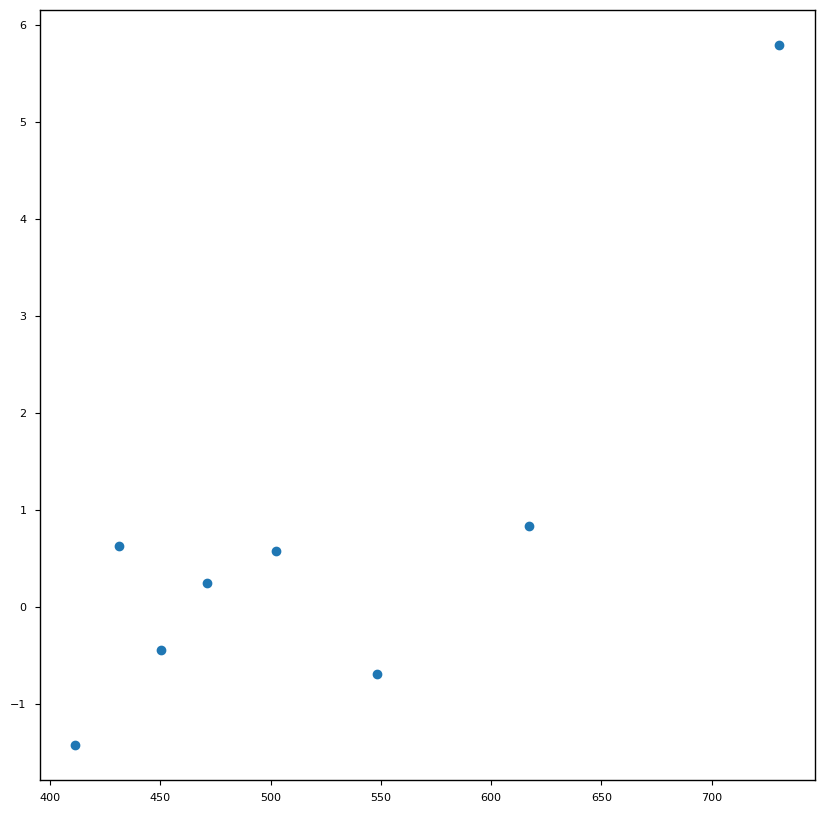

0.7704915548176198


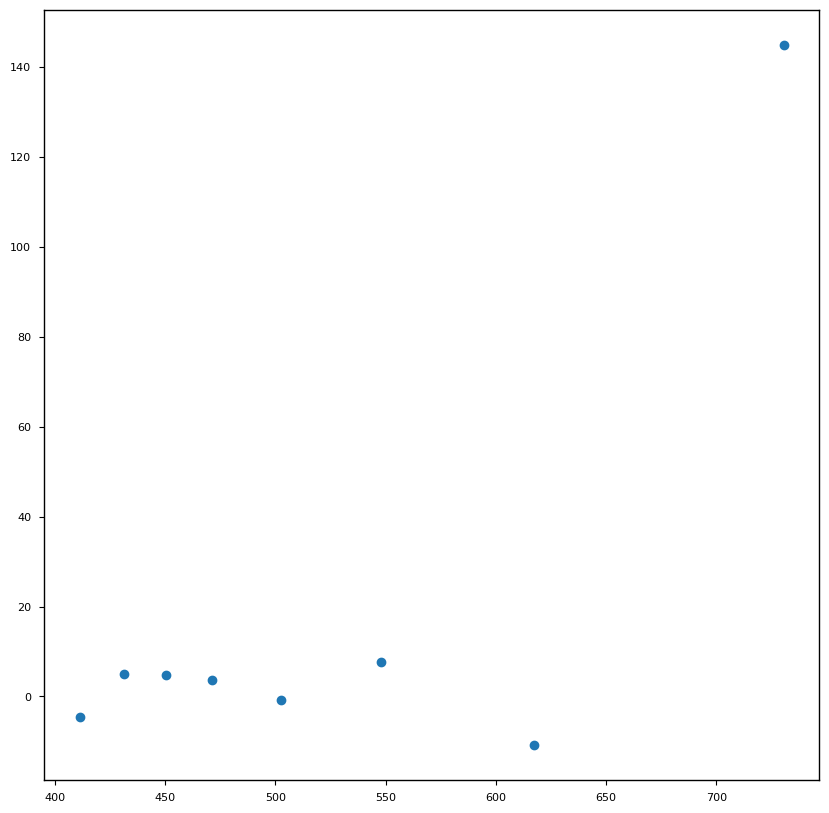

6.002192297358861


In [47]:
mod=1000*scint_freq_relation(f_cents,result_scint1.params['c'].value,result_scint1.params['n'].value)
data=1000*np.array(sub_scint)


plt.scatter(f_cents,data-mod)
plt.show()

print(np.std(data[:-1]-mod[:-1]))
      
mod=1000*scint_freq_relation(f_cents,result_scint2.params['c'].value,result_scint2.params['n'].value)
data=1000*np.array(sub_scint2)

plt.scatter(f_cents,data-mod)
plt.show()

print(np.std(data[:-1]-mod[:-1]))

In [48]:
print(np.nanmean(mods2[:-1]),'+-',np.nanstd(mods2[:-1]))
print(np.nanmean(mods1[1:-1]),'+-',np.nanstd(mods1[1:-1]))

0.7820142716785605 +- 0.07758565733683002
1.2187034546654896 +- 0.1340913242797985
